# Qunomon利用チュートリアル
## 1.はじめに
- 本チュートリアルでは、「石造りの外壁画像を入力し、欠陥の有無を判別するタスク」を題材に、Qunomonを用いてデータセット・モデル等の品質評価を行う事例を紹介します。
- 本チュートリアルは[機械学習品質マネジメントリファレンスガイド](https://www.digiarc.aist.go.jp/publication/aiqm/referenceguide.html)の第1.1版 8章の内容を参考にしています。
  - あくまで参考です。お手元で実際にチュートリアルを試していただけるよう、制約の弱いデータセットを対象としており、課題の細部は異なります。
  - テストベッドの使用シーンをわかりやすくつかんでいただけるよう、評価順序なども変わっております。

### 1.1.目次
- 1.はじめに
  - 1.1.目次
  - 1.2.シナリオ紹介
- 第一部 Qunomonを用いた機械学習コンポーネントの評価
  - 2.チュートリアル用の資材準備
  - 3.データセットの準備
    - 3.1.データセットのダウンロード
    - 3.2.データセットの配置
    - 3.3.データセットの整形
  - 4.Qunomonを用いた評価
    - 4.1.Qunomonのダウンロードとインストール
    - 4.2.Qunomonの起動
    - 4.2.AITのインストール
    - 4.3.機械学習コンポーネント（Inventory）の登録
    - 4.4.テスト仕様（Test Description）の登録
    - 4.5.評価の実行と結果確認
- 第二部 機械学習コンポーネントの準備方法
  - 5.推論モデルの準備
    - 5.1.モデルの構築
    - 5.2.モデルの訓練
    - 5.3.モデルの検証
  - 6.推論モデルの訓練方式を変えた場合の評価の変動

### 1.2.シナリオの概要
#### 1.2.1.シナリオの流れ
本シナリオでは、石造りの構造物の一部を撮像した画像データを入力とし、対象物に欠陥（ひび割れ）が存在するかどうかを判別するタスクを機械学習を使って解く過程を通じて、Qunomon（機械学習品質テストベッド）の使用方法や効果を理解してもらうことを目指す。
対象物のひび割れの有無の自動的な検知は、構造物の耐久性や現時点における品質を判定し、応用タスクによっては対処の必要性を判断することにも使える、実用性のあるタスクであり、建築・土木業界等での実際の応用例も多数知られている。

以降、本ノートブックでは、まず与えられたデータセット・モデルに対する一般的なQunomon使用法を学習してもらう目的で、
- チュートリアル資材・データセットの準備
- Qunomonのインストール
- AITHubからQunomonへのAIT（テストパッケージ）の導入
- 評価の実行
- 評価レポートの閲覧

について解説する。

その後、より具体的な内容に踏み込みたい読者に向け、実際のデータセット・モデルの準備を伴う実行可能なチュートリアルとして
- データセット準備（保存・加工）
- モデル構築
- モデル訓練

を解説したのち、
- データセットやモデルへの加工がQunomon上での評価にどう影響するか

を確認してもらう。

#### 1.2.2.シナリオの到達目標
本シナリオの到達目標としえｔ、全シナリオを実際に手元で動作させた読者が
- Qunomonのインストール・起動・基本操作
- QunomonへのAITの導入
- Qunomonを用いた機械学習コンポーネントの評価
- 標準的なAITで想定される機械学習コンポーネントの保存形式の取り扱い方法

を実現できるようになることを目指します。

----

# 第一部 Qunomonを用いた機械学習コンポーネントの評価

----

## 2.チュートリアル用の資材準備
- チュートリアル資材をまとめた圧縮ファイルをこちらからダウンロード
- Qunomon本体はこちらからダウンロード

#### 2.1.ディレクトリ構成
チュートリアル資材のzipファイルを解凍すると、下記のディレクトリ構造でデータが保存されています。

```Markdown
- best_practice_1/
  - notebooks/
    - notebook.ipynb `(このノートブック)`
  - resources/
  - poetry.lock
  - pyproject.toml
  - requirements.txt
```

本ノートブックの実行に必要な依存関係はpoetryで管理しています。
下記のようにpoetryをインストールし、ディレクトリ直下に.venvを生成するか、もしくはrequirements.txtを用いて好みの方法で依存関係のインストールを行ってください。

```bash
cd best_practice_1
pip install poetry
poetry config virtualenv.in-project True
poetry install
```

----

## 3.データセット準備
- シナリオは、ユタ州立大学より公開されている[SDNET2018](https://digitalcommons.usu.edu/all_datasets/48/)データセットを対象としたものです。
  - 出典
    - Maguire, M., Dorafshan, S., & Thomas, R. J. (2018). SDNET2018: A concrete crack image dataset for machine learning applications. Utah State University.
    - DOI: https://doi.org/10.15142/T3TD19
  - 本データセットは、[Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) (CC-BY-4.0) ライセンスのもとで公開されている。
    - 本チュートリアルではデータセットの再配布は行わない。
    - 読者がチュートリアルノートブックを実行し、ダウンロードしたデータセットを取り扱う際の責任は、読者自身に帰す。
    - 必ずライセンス要件を確認し、その内容に従ってデータを取り扱うことを要請する。
- 以降、本節ではこちらのデータを今回の機械学習シナリオおよび評価に適した形式へと適宜整理します。

### 3.1.データセットの配置
ダウンロードしたSDNET2018データセットを解凍し、下記のディレクトリ構造となるようにresources直下に配置してください。

- best_practice_1/
  - notebooks/
    - notebook.ipynb
- resources/
  - SDNET2018/
    - P/
      - CP/
      - UP/
    - D/
      - CD/ 
      - UD/ 
    - W/
      - CW/ 
      - UW/

ここで, P, D, Wはそれぞれ舗装（Pavement）、橋板（Deck）、壁面（Wall）を表し、サブディレクトリのC, Uはそれぞれ割れあり(Cracked)、割れなし（Uncracked）を表しています。
例えば、「CP」であればCracked Pavementなので割れのある舗装画像となり、その直下に該当クラスの画像ファイルが格納されています。

### 3.2 データセットの整形
#### 3.2.1 torch.data.ImageFolder向けのディレクトリ様式変換と訓練／検証／テスト分割

本シナリオの目的は構造物のひび割れ有無の判定ですので、Deck, Pavement, Wallのクラスは使わず、Cracked, Uncrackedのみが分類対象となります（二値分類）。
そこで、下記コマンドを用いて二値分類用のデータセットを作成しましょう。

In [ ]:
import os
import shutil

os.makedirs("../resources/SDNET2018binary", exist_ok=True)
os.makedirs("../resources/SDNET2018binary/Cracked", exist_ok=True)
os.makedirs("../resources/SDNET2018binary/Uncracked", exist_ok=True)

shutil.copytree("../resources/SDNET2018/D/CD", "../resources/SDNET2018binary/Cracked", dirs_exist_ok=True)
shutil.copytree("../resources/SDNET2018/P/CP", "../resources/SDNET2018binary/Cracked", dirs_exist_ok=True)
shutil.copytree("../resources/SDNET2018/W/CW", "../resources/SDNET2018binary/Cracked", dirs_exist_ok=True)

shutil.copytree("../resources/SDNET2018/D/UD", "../resources/SDNET2018binary/Uncracked", dirs_exist_ok=True)
shutil.copytree("../resources/SDNET2018/P/UP", "../resources/SDNET2018binary/Uncracked", dirs_exist_ok=True)
shutil.copytree("../resources/SDNET2018/W/UW", "../resources/SDNET2018binary/Uncracked", dirs_exist_ok=True)

import glob
Dlen = len(glob.glob("../resources/SDNET2018/D/**/*"))
Plen = len(glob.glob("../resources/SDNET2018/P/**/*"))
Wlen = len(glob.glob("../resources/SDNET2018/W/**/*"))
Copiedlen = len(glob.glob("../resources/SDNET2018binary/**/*"))
print(f"D:{Dlen}, P:{Plen}, W:{Wlen}, Total={Dlen+Wlen+Plen}, Copied={Copiedlen}")

In [ ]:
import splitfolders
splitfolders.ratio("../resources/SDNET2018binary",
                   output="../resources/SDNET2018splitted",
                   seed=1337,
                   ratio=(.8, .1, .1),
                   group_prefix=None,
                   move=False)

#### 3.2.2 Qunomonでの評価に備えた前処理済データセット（HDF5形式）の生成

学習用途にはこの状態で使用することもできますが、今回はモデルの評価のため、訓練時に行ったデータ前処理後のデータセットをHDF5形式で保持する必要があります。（Qunomon開発チームでは、ポータビリティの観点から評価時に用いるデータセットの保存形式に前処理済HDF5形式を推奨しています）

なお、本シナリオの評価対象モデルは

In [ ]:
import h5py
import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ImageNetで訓練済の重みを使用する際は、訓練時に下記の正規化処理が入っているため、再現
# また入力サイズは224*224に固定する。
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
test_transform = v2.Compose([v2.Resize(224, antialias=None), v2.CenterCrop(224), v2.ToTensor(),  normalize])

# 訓練データと、過学習モデルの採用を防ぐためのvalデータを用意しておきます。
test_dataset = ImageFolder("../resources/SDNET2018splitted/test", transform=test_transform)
# train_dataset = ImageFolder("../resources/SDNET2018splitted/train", transform=test_transform)
# val_dataset = ImageFolder("../resources/SDNET2018splitted/val", transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

前処理済みデータの見た目を確認しておきます。

In [ ]:
for i, d in enumerate(test_dataloader):
    print(f"{d[0].numpy().shape}, {d[1].numpy().shape}, {d[1][0]}={test_dataset.classes[d[1][0]]}")
    plt.imshow(d[0][0].permute(1, 2, 0))
    break

最後にHDF5形式に保存していきます。

In [ ]:
f = h5py.File('../resources/test_preprocessed.h5', 'w')
for i, data in enumerate(test_dataloader):
  new_data = data[0].numpy()
  new_label = np.expand_dims(data[1].numpy(), axis=1)
  
  if i == 0:
    # Create the dataset at first
    f.create_dataset('data', data=new_data, compression="gzip", chunks=True, maxshape=(None,3,224,224))
    f.create_dataset('label', data=new_label, compression="gzip", chunks=True, maxshape=(None,1)) 
  else:
    # Append new data to it
    f['data'].resize((f['data'].shape[0] + new_data.shape[0]), axis=0)
    f['data'][-new_data.shape[0]:] = new_data

    f['label'].resize((f['label'].shape[0] + new_label.shape[0]), axis=0)
    f['label'][-new_label.shape[0]:] = new_label

  print("I am on iteration {} and 'data' chunk has shape:{}".format(i,f['data'].shape))
  
#  NOTE: お手持ちのマシン上でQunomonを動作させる際、評価用データセットが大きすぎるとメモリに乗り切らない場合があります。
#  そのような場合は、下記のコードをコメントアウトし、データセット全体の一部のみを保存してテストしてみてください。
#   if i == 31: 
#     break

f.close()

## 4.Qunomonを用いた評価
ここからは、準備したデータセットと、シナリオにあわせて訓練されたモデル（4.3.で配布します）をQunomonに登録し、評価結果を確認するまでの流れを解説します。
Qunomonは産業総合技術研究所が開発した機械学習コンポーネントの品質評価テストベッド（プラットフォーム）です。
オープンソースのWebアプリケーションとして開発され、Dockerを用いて構成管理が行われているため、誰でもインターネット上からダウンロードして機械学習コンポーネントの品質評価を行えます。

Qunomonは前述の通りWebアプリケーションですので、本章（特にアプリ起動以降）では、いわゆる説明書のように画面のスクリーンショットを提示しながら解説を行います。
読者の皆様は本資料を参考にしながらお手持ちのマシン上での実行をお試しください。

### 4.1.Qunomonのダウンロードとインストール
下記のWebサイト群を参考に、Qunomonのダウンロードとインストールを行ってください。
- [Qunomonランディングページ](https://aistairc.github.io/qunomon/)
- [Qunomonリポジトリ(GitHub)](https://github.com/aistairc/qunomon)

以下に一般的な手順を示しておきます。
- Qunomonのダウンロード
  - 本ドキュメントはQunomon β版に依拠して執筆されています。
  - [リリースページ(20231122_β版リリース)](https://github.com/aistairc/qunomon/releases/tag/1.0.0)よりソースコードをダウンロードし、適当なディレクトリ下に配置してください。
- 前提ソフトウェアの準備
  - QunomonはDockerを用いて構成されていますので、動作環境にはDockerが導入されている必要があります。
  - Windowsの場合は、[Docker公式の解説](https://docs.docker.com/get-docker/)等を参考に導入されてください。
    - Docker公式ドキュメントは、Windows/Mac環境へのDocker導入に際して、Docker Desktopの利用を推奨しています(2023/12月現在）。
    - Docker Desktopには商業規模・従業員規模に基づくライセンス制約が存在しますので、ご利用の際は公式ドキュメントのライセンスをご確認の上、自己責任で導入されてください。
    - Docker Desktopの導入が難しい場合は、WSL(Windows Subsystem for Linux)環境上にDockerを導入する手順がありますが、公式にはサポートされておらず、本ドキュメントでも手順の詳細についてはスコープ外とします。

### 4.2.Qunomonの起動
- [Qunomonユーザーズ・ガイド](https://github.com/aistairc/qunomon/blob/main/qunomon/doc/USER_MANUAL/doc_jp/01_Introduction/01_Introduction.md)を参照してください。
- 以下に一般的な手順を示しておきます。
  - 一行目ではソースファイルのルートからさらに一段下ったqunomonディレクトリへ遷移しています。
  - 二行目で同ディレクトリ内の `docker-compose.yaml` を参照してDockerコンテナ群を起動しています。

``` bash
cd ./qunomon/qunomon
docker-compose up -d
```

上記コマンドの実行が完了した後、Qunomon実行環境上のブラウザから`https://127.0.0.1`にアクセスすることで、アプリが起動できます。

> 起動時の画面の例。評価対象の機械学習コンポーネント一覧の画面にリダイレクトされますが、この時点では何も登録していないため空の表が表示されています。
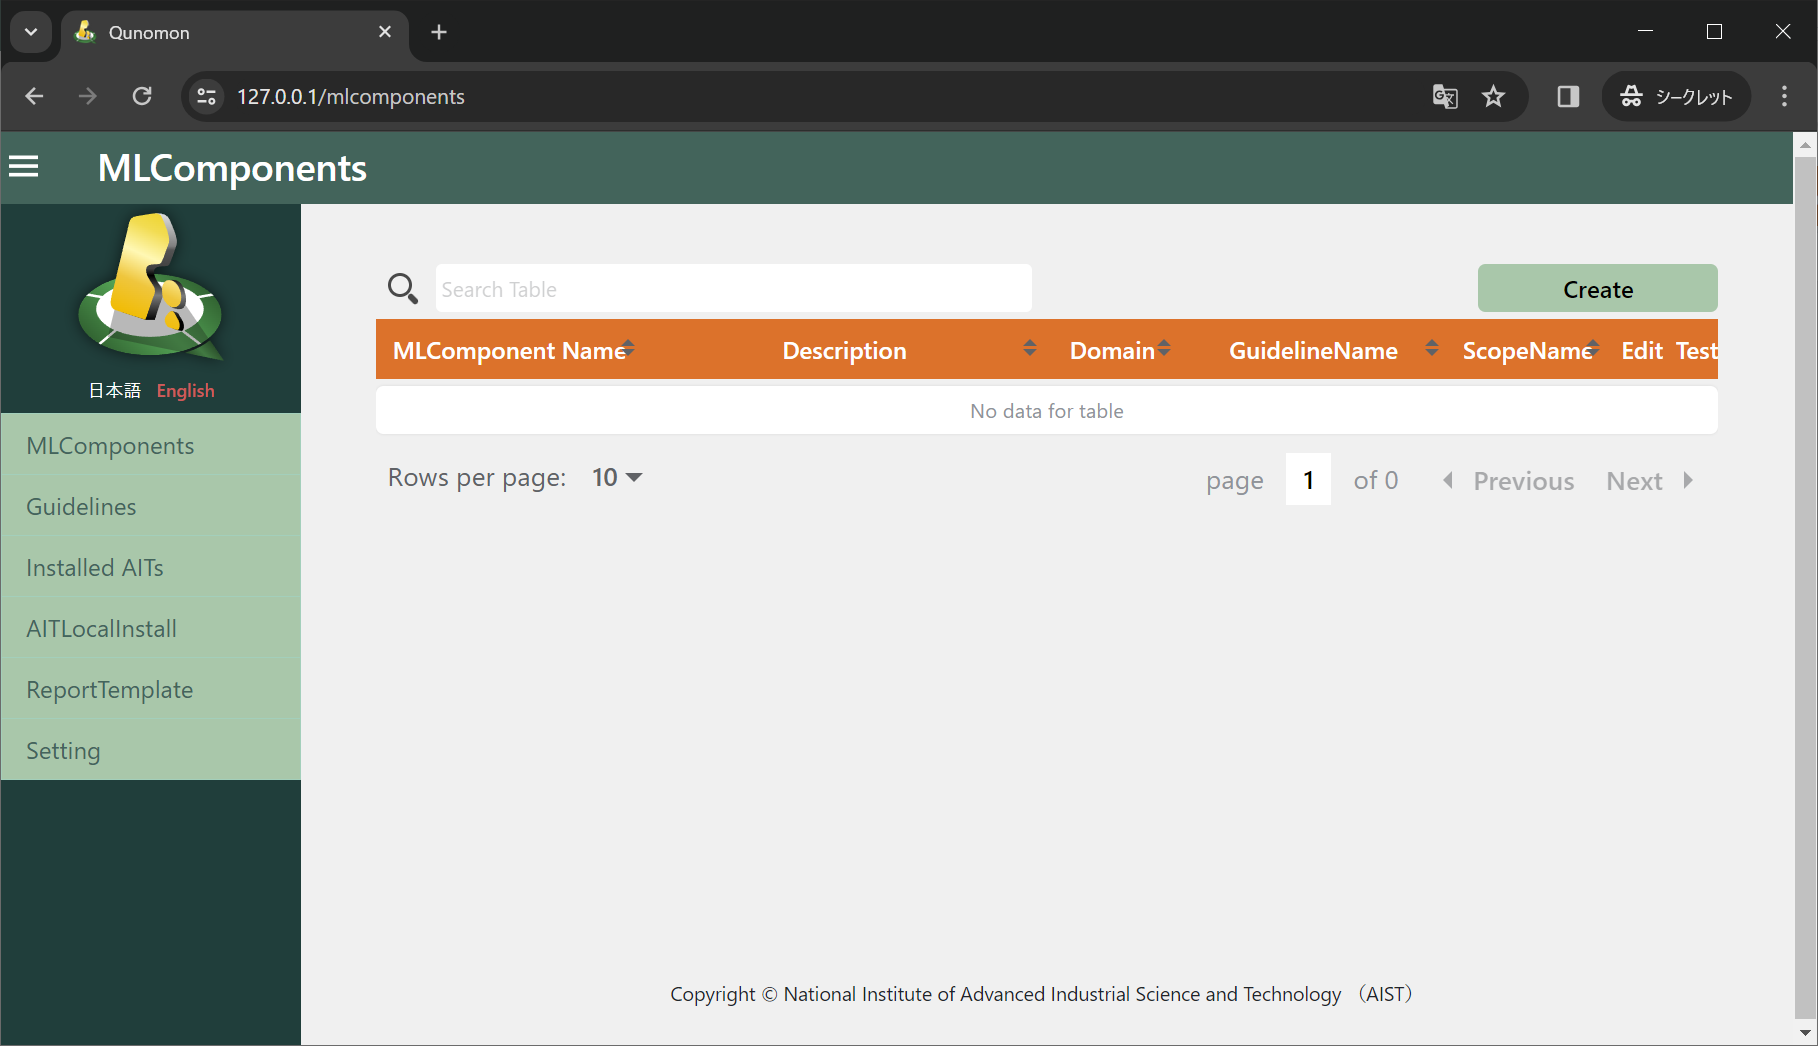

### 4.3.AITのインストール
次に、本シナリオの機械学習コンポーネント（モデルとデータセット）の評価を行うAITをインストールします。

AITは実行可能な評価手法パッケージとなっています。AITのインストール方法には、(1)産総研の運営するAIT Hubからダウンロードする方法と、(2)ローカルで開発あるいは第三者が提供しているAITをローカル環境から登録する方法があります。

本シナリオでは以降、(1)の手順を説明します。

> 【手順1】まずはAIT Hubとローカル環境の連携設定を行います。左ペインより「Setting」を押下し、設定画面へ移動してください。  
> 続いて、AIT HubはGitHubアカウントを用いてユーザ認証を行いますので、AIT-HUB loginボタンを押下します。

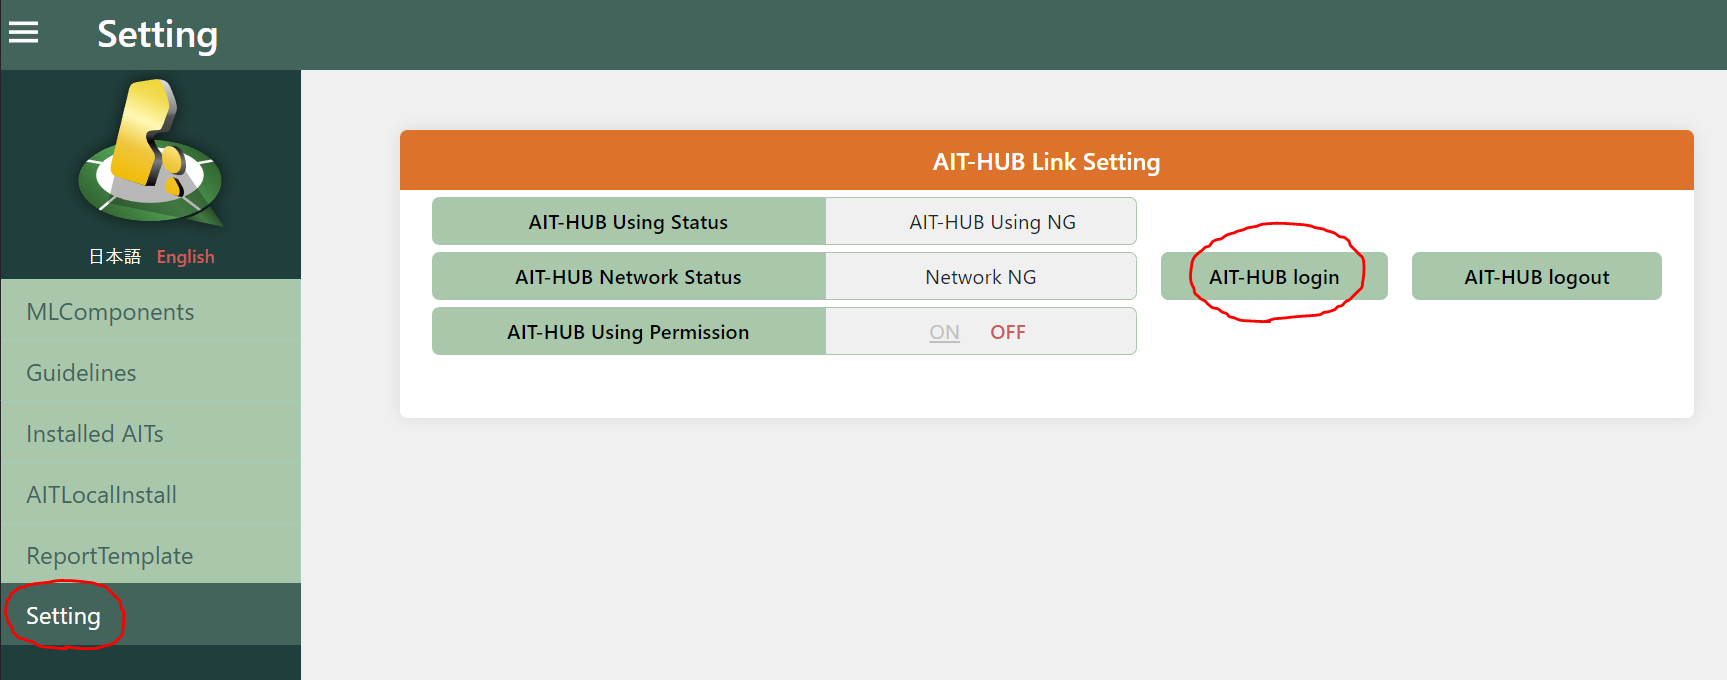

> 【手順2】認証画面からAIT Hubに通知済のメールアドレスに紐づいたGitHubアカウントでログインを実施します。

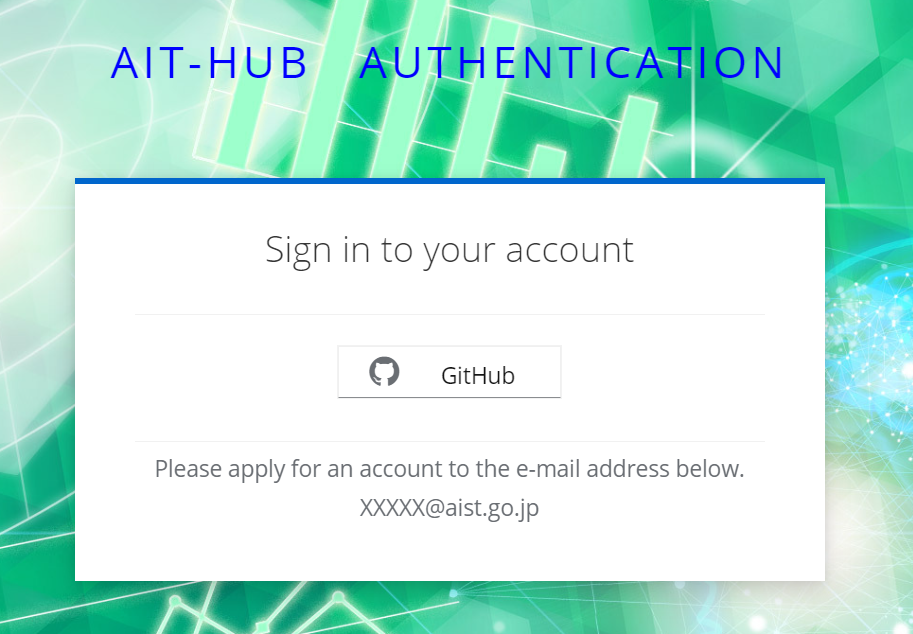
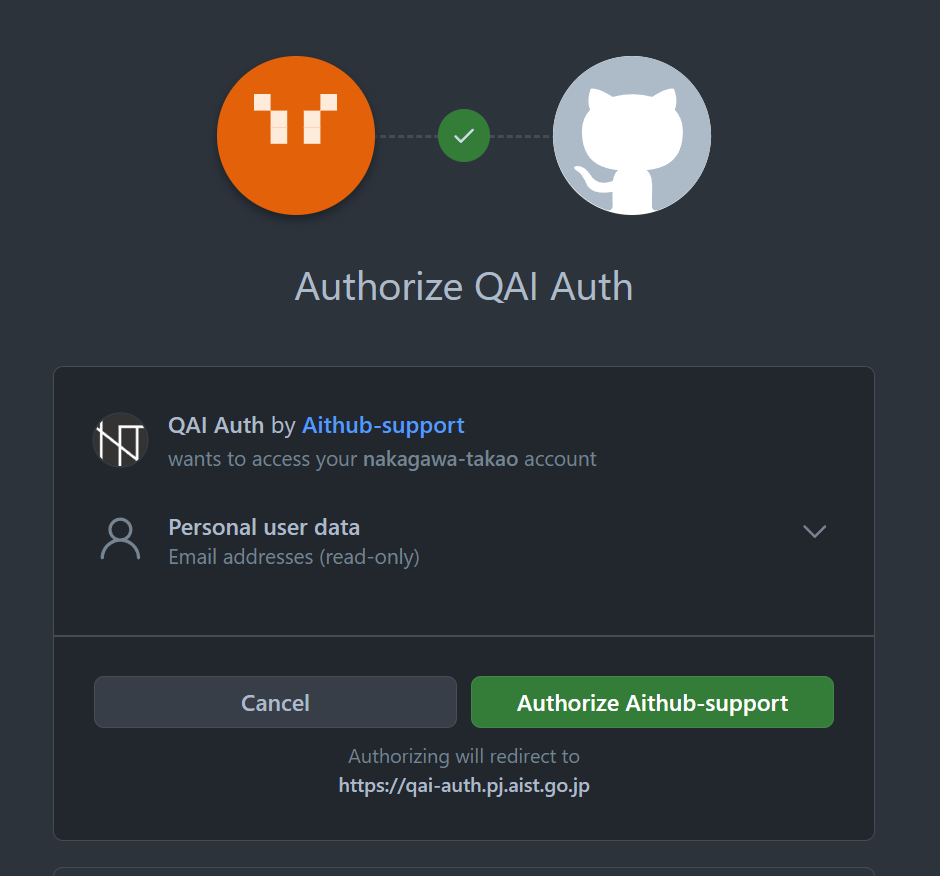

> 【手順3】設定画面に戻り、AIT HubからのAITインストールを許可してください。

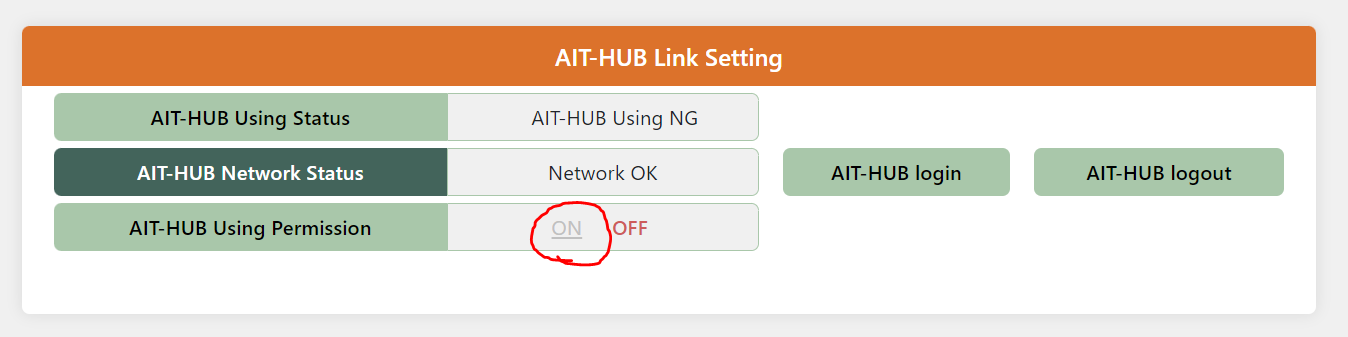

> 【手順4】連携が完了すると、左ペインにAIT Search機能とAITHub Ranking機能が表示されるようになります。

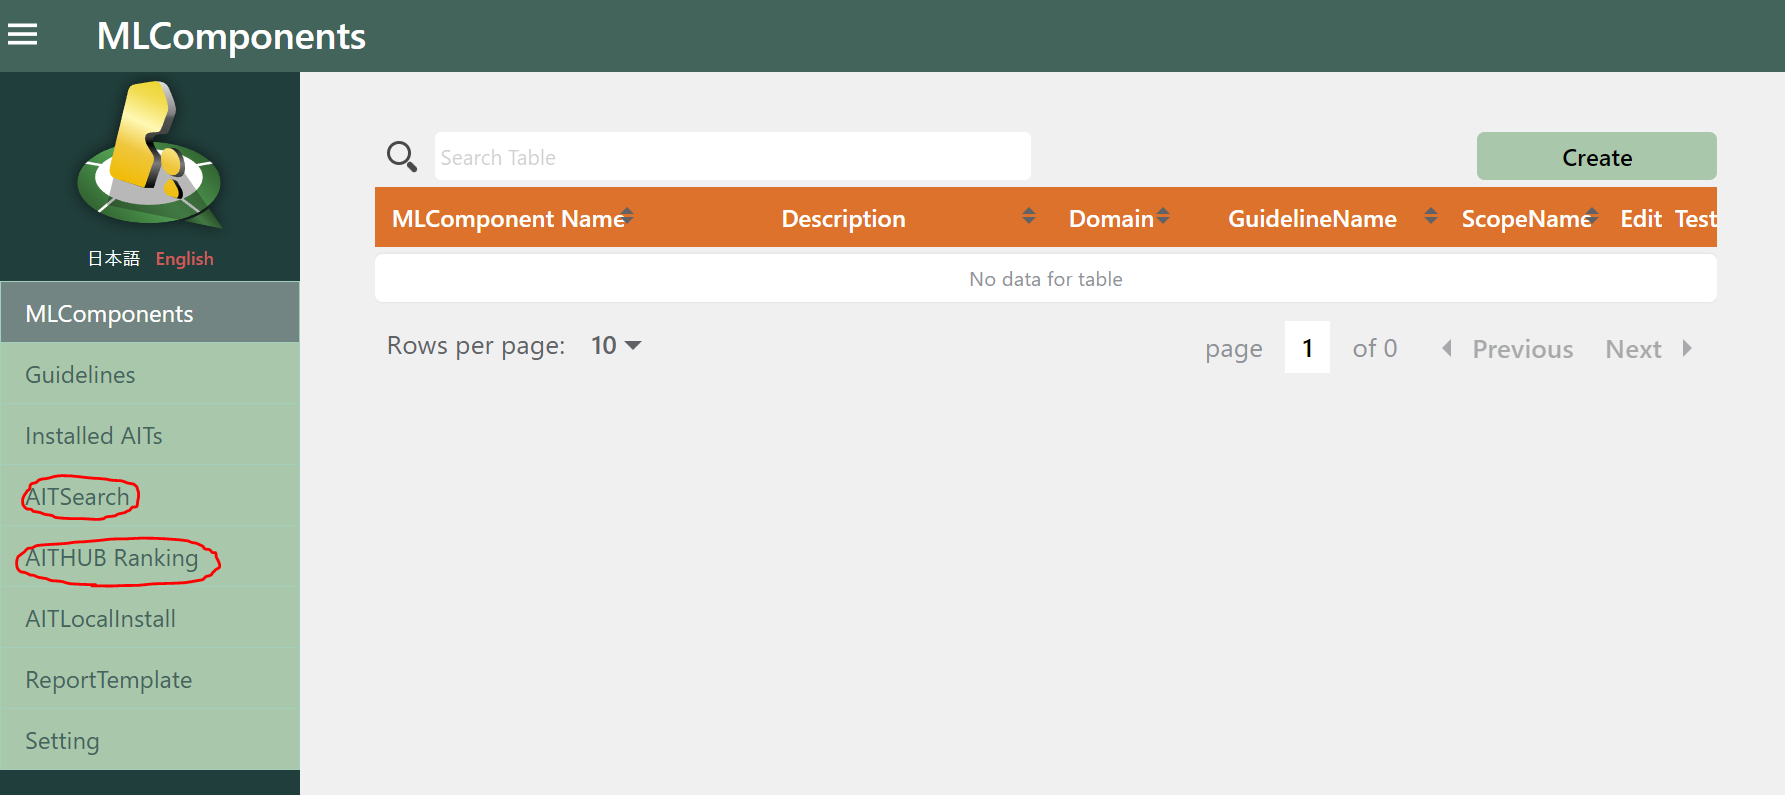

> 【手順5】今回はAIT Search機能を使います。  
> インストールするAITは、評価対象とデータ形式が一致する必要があります。  
> Qunomonでは"インベントリ"がデータの受け皿となり、AITとインベントリ内のデータの相互運用性を管理します。  
> 今回は、Torchscript形式の画像分類モデルを評価しますので、検索画面に下記を入力し、Searchボタンを押下してください。  
> Search Category: インベントリ情報  
> Search Keyword: TorchScript  

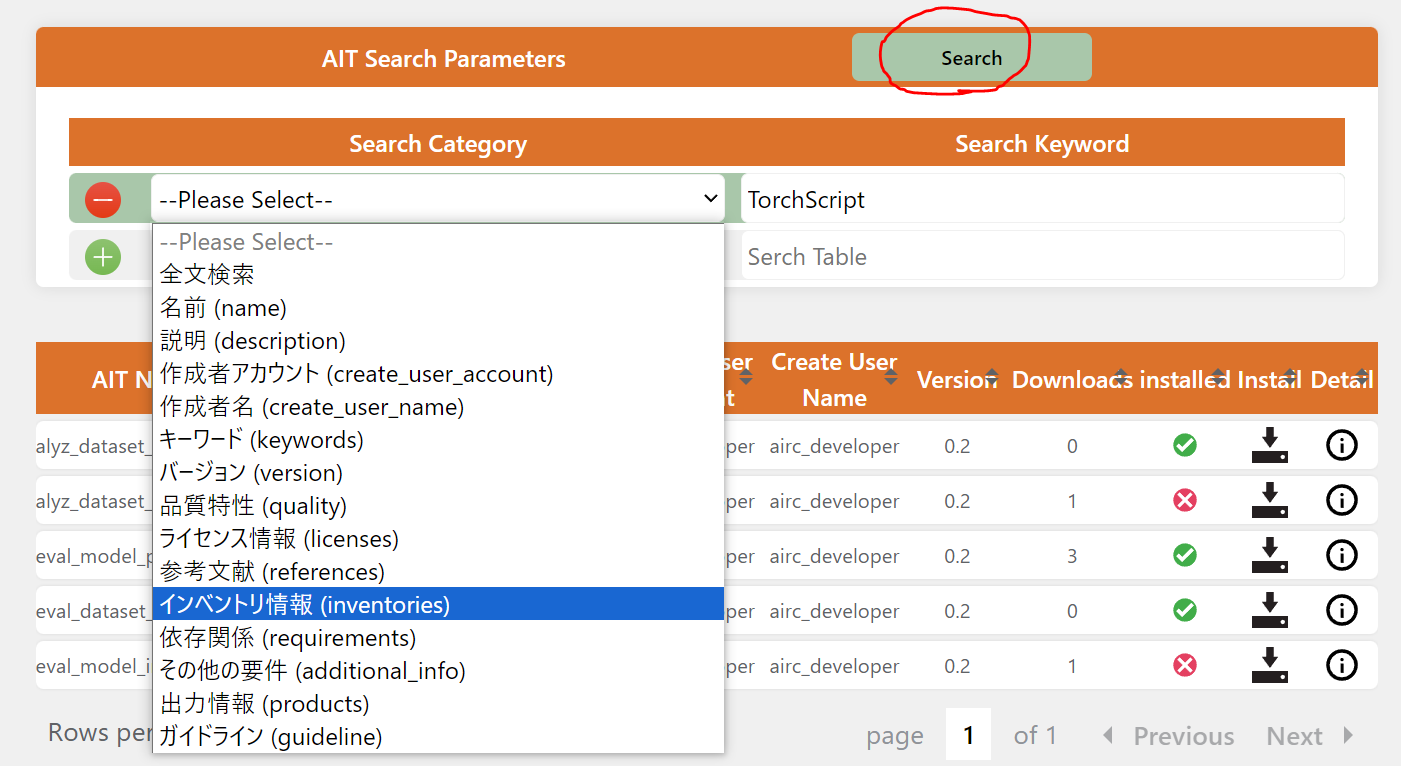

> 【手順6】右のボタンでAITの詳細を確認してから、左のボタンでAITをインストールしてください。  
> AITのダウンロード・インストールは自動的に進行し、完了後はQunomon上で選択して評価に使える状態となります。

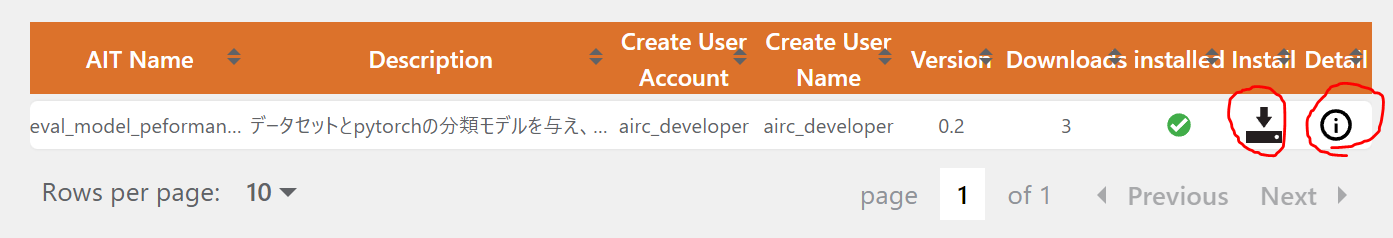

> 下記のようにInstalled AIT画面に表示されていれば成功です。

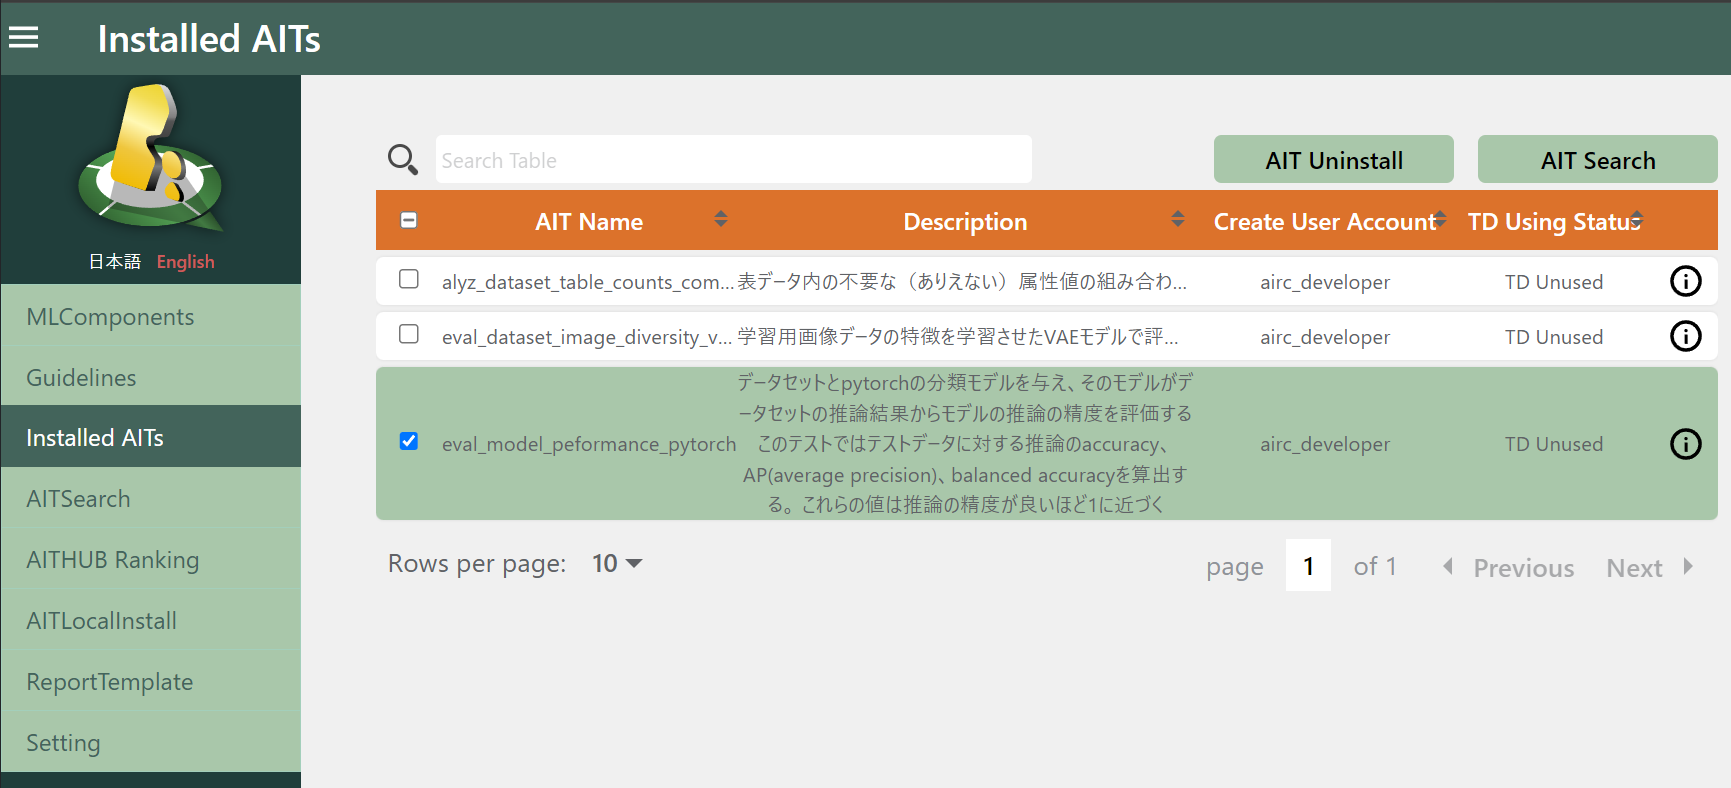

### 4.4.機械学習コンポーネント（MLComponent）の登録
- ここからは、評価対象となる機械学習コンポーネントの登録を行います。
  - 機械学習コンポーネントとは、機械学習システムで用いられる特定の機械学習を用いた機能あるいはモジュールの単位です。複数のモデルやデータセットを管理（品質評価）対象として含む場合があります。
- [MLComponent](https://127.0.0.1/MLComponents)画面へ遷移し、右上のCreateボタンから新たな機械学習コンポーネントを登録しましょう。

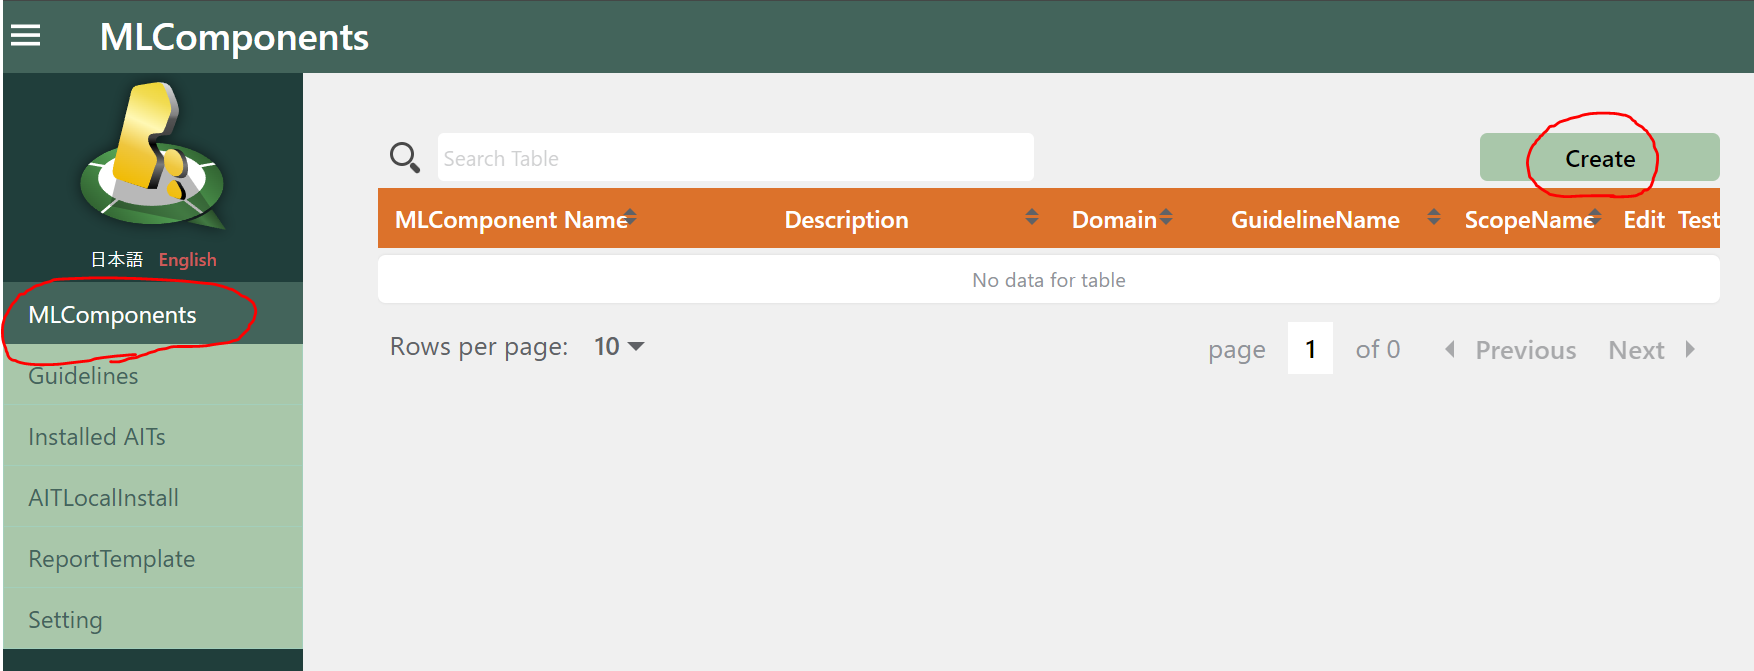

- 後から参照しやすくするため、機械学習コンポーネントの名称と説明を設定する必要があります。
  - ここでは以下の画像のように設定しておきましょう。自由記述ですがタスクのドメインは画像のクラス分類ですので、画像分類としておきます。

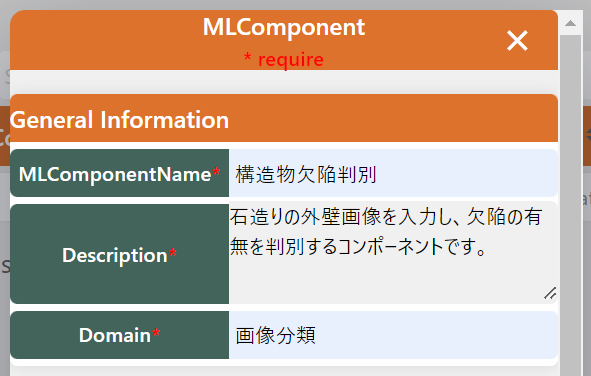

- Qunomonを用いた品質管理では、どのガイドラインや標準に従って品質評価を行っているのかを管理することで、評価観点の抜け・漏れや、ガイドライン・標準に対する適合性を管理します。
  - ここでは最初から設定されている産総研の「機械学習品質マネジメントガイドライン　第三版」を設定しておきましょう。
- ガイドラインがドメインやタスク種別ごとに異なる品質特性の管理を要求している場合があります。このとき、「スコープ」は今回対象とする機械学習コンポーネントについて管理すべき品質特性をまとめたものです。
  - 機械学習品質マネジメントガイドラインでは、取り扱いスコープがひとつしかありませんので、これを選択しておいてください。
  - ただし、生成系モデルや強化学習などについては今回選択したスコープ（ガイドラインの対象スコープ）の対象となっていません。あらかじめガイドラインを読んだうえで、開発中の機械学習コンポーネントがガイドラインの管理対象となるスコープに含まれるかどうかは品質評価者自身で判断するようにしてください。

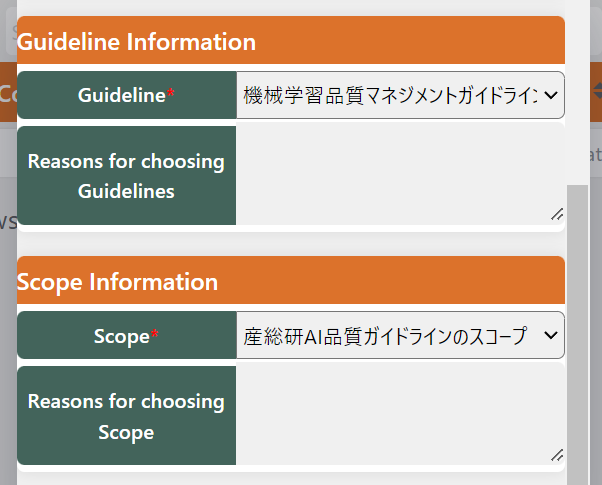

- 次の項目に進む前に、登録した機械学習コンポーネントの詳細画面に遷移しておきましょう。
  - 機械学習コンポーネントの詳細画面では、機械学習コンポーネントを構成する個々の資産（モデル、データセット）と、個々の資産を複数のインストール済AITで評価するテスト仕様を管理します。
  - それぞれ、個別の資産はInventory（インベントリ）、テスト仕様はTest Description（テスト・デスクリプション）という枠組みで管理が行われます。

### 4.5.テスト仕様（Test Description）の登録
- 次に、テスト仕様の登録を行います。
  - まずMLComponent画面に4.4で作成した構造物欠陥判別コンポ―ネントが登録されていることを確認してください。
  - 確認出来たら、右端の「テスト」列のボタンを押下し、テスト仕様登録画面へ遷移します。
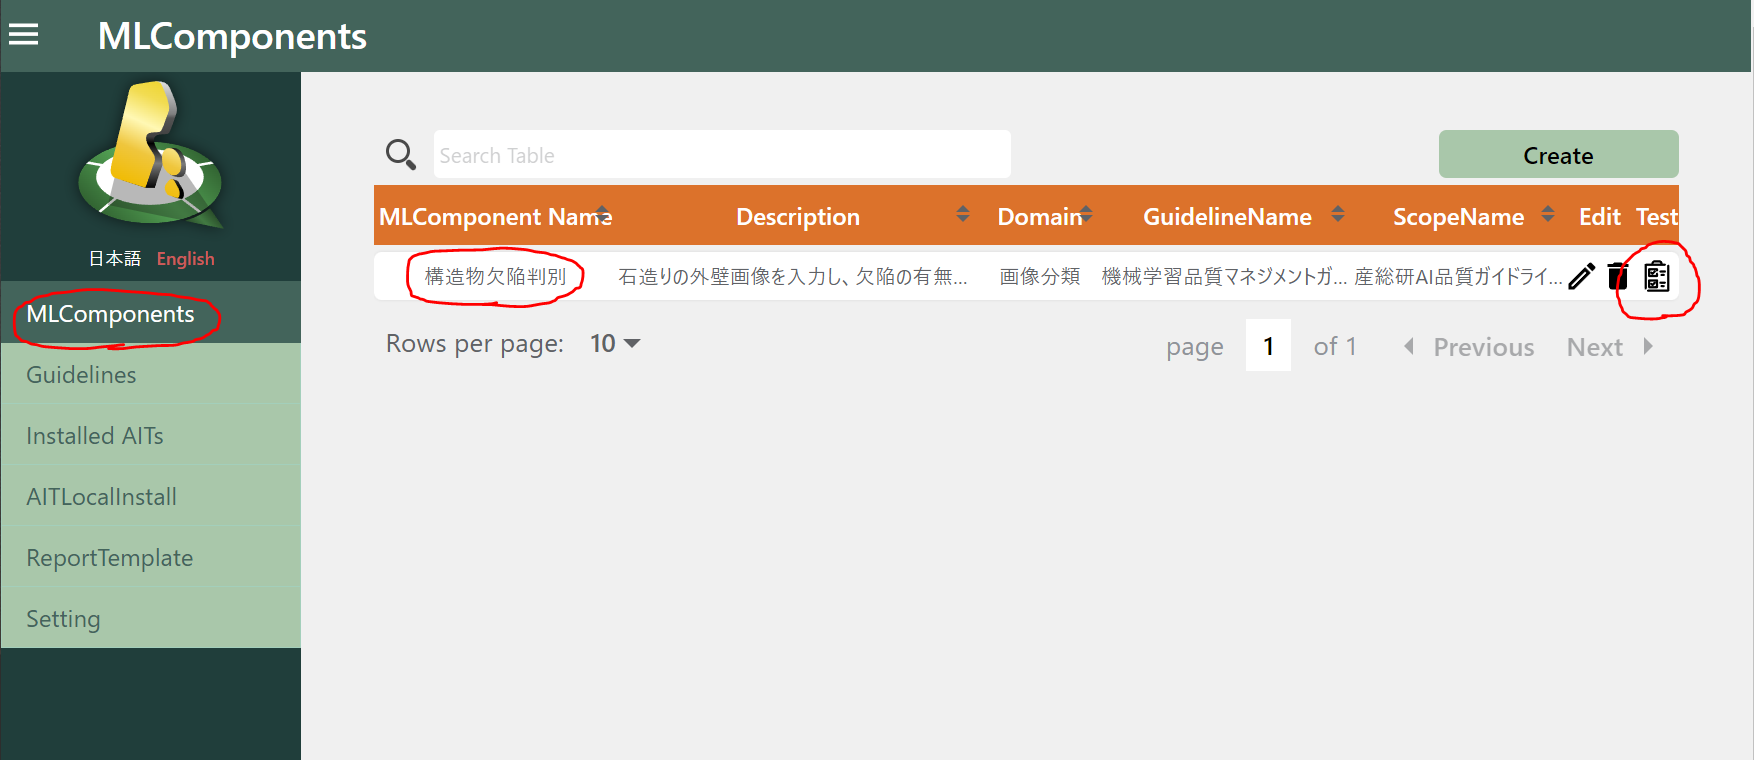

#### 4.5.1.テスト対象資産のインベントリへの登録
- テスト仕様を登録する前に、テスト対象資産（テストしたいデータセットやモデル）を、MLComponentのインベントリ領域に格納する必要があります。テスト時には、ここに登録されたテスト対象資産がAITから参照され、検査されます。
- 以下はテスト仕様登録画面からテスト対象資産の登録を行う手順になります。

> 【手順1】構造物欠陥判別 MLComponent のテスト仕様登録画面から Inventories を押下

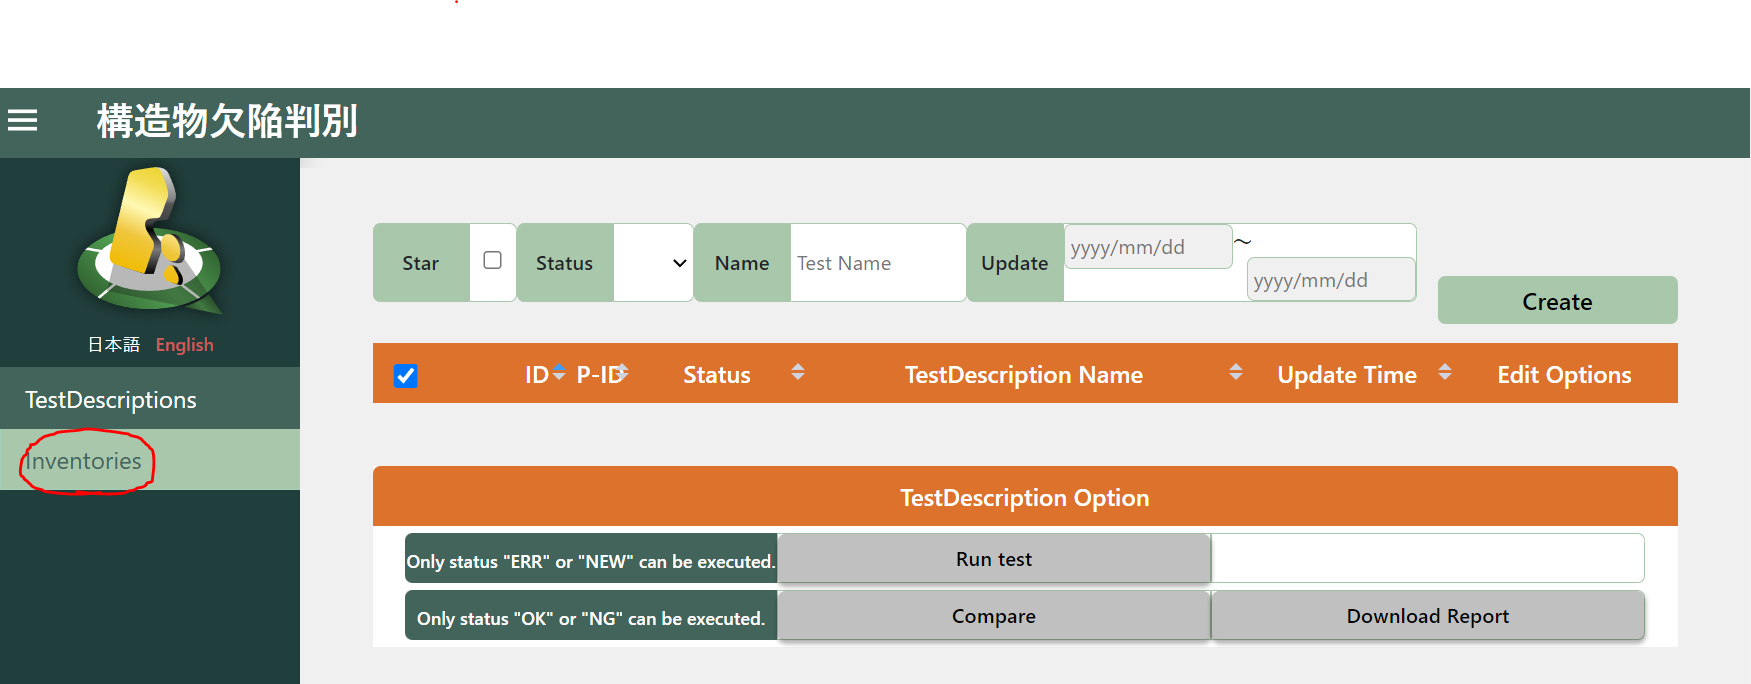

> 【手順2】構造物欠陥判別 MLComponent のインベントリ一覧画面から Create を押下

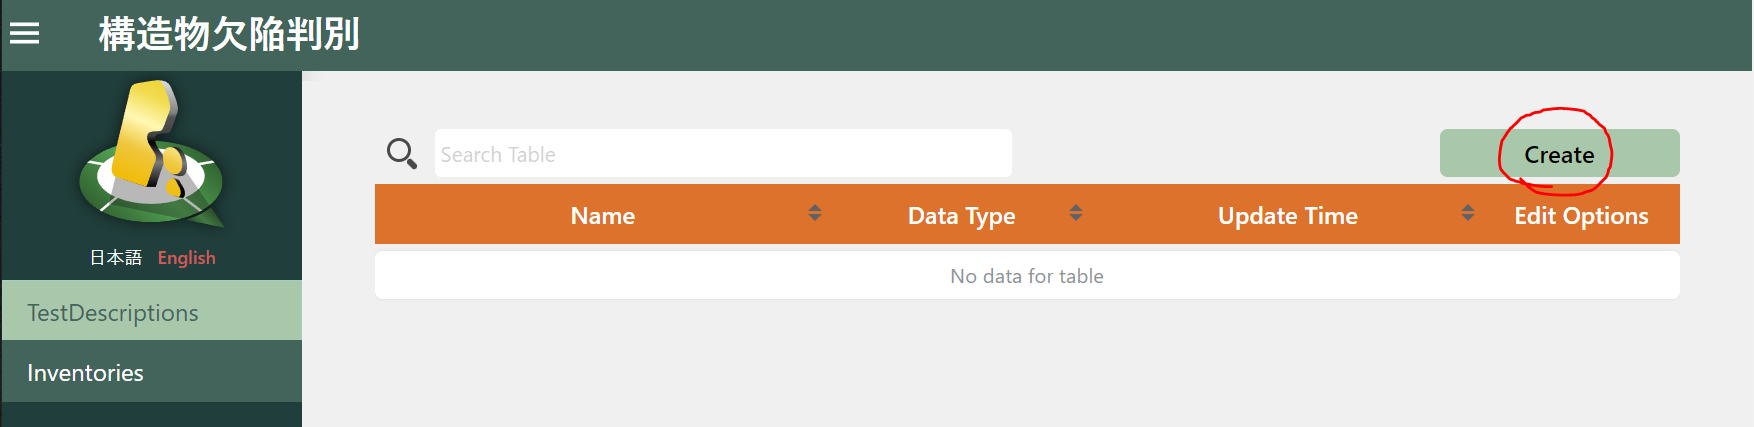

> 【手順3】まずはモデルを登録します。Torchscript形式に変換されたモデル (こちらからダウンロード) をPC上に配置し、Path欄にはそのファイルパスを入力してください。
> Nameには他のアセットと判別しやすい名前をつけてください。DataTypeは登録する資産に適合するものを選んでください。ここではmodelとなります。Formatはファイルフォーマットです。拡張子よりpthを選択します。
** 今回のチュートリアルと同等のモデルを訓練し、Torchscript形式で保存する方法については後述します。第二部 5章を参照してください！ **

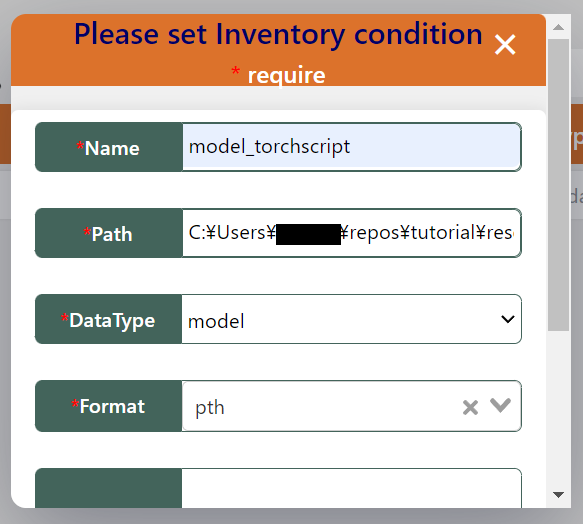

> 【手順4】同じくデータセットを登録します。3.2.2.節で生成したHDF5形式のデータセットのファイルパスを指定してください。
> 3.2.2.のコード内にコメントアウトされている通り、マシンスペックによってはテスト実行時にメモリ不足を起こす可能性があります。適宜テスト用データセットのサイズを小さくしてお試しください。

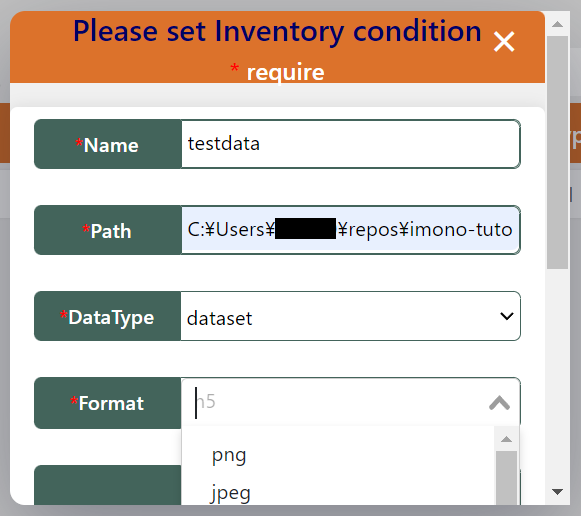

> 【手順5】登録が完了したら、テスト仕様登録画面に戻ってください。

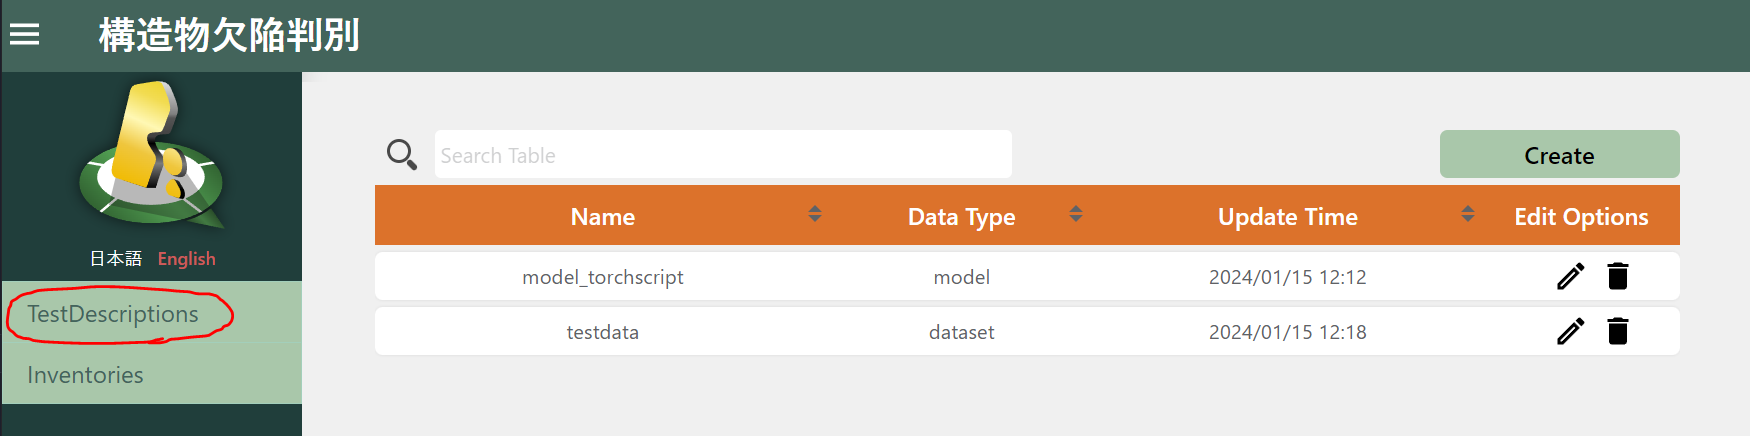

#### 4.5.2.テスト仕様の登録
- テスト仕様の登録を行います。

> 【手順1】テスト仕様登録画面へ遷移します。

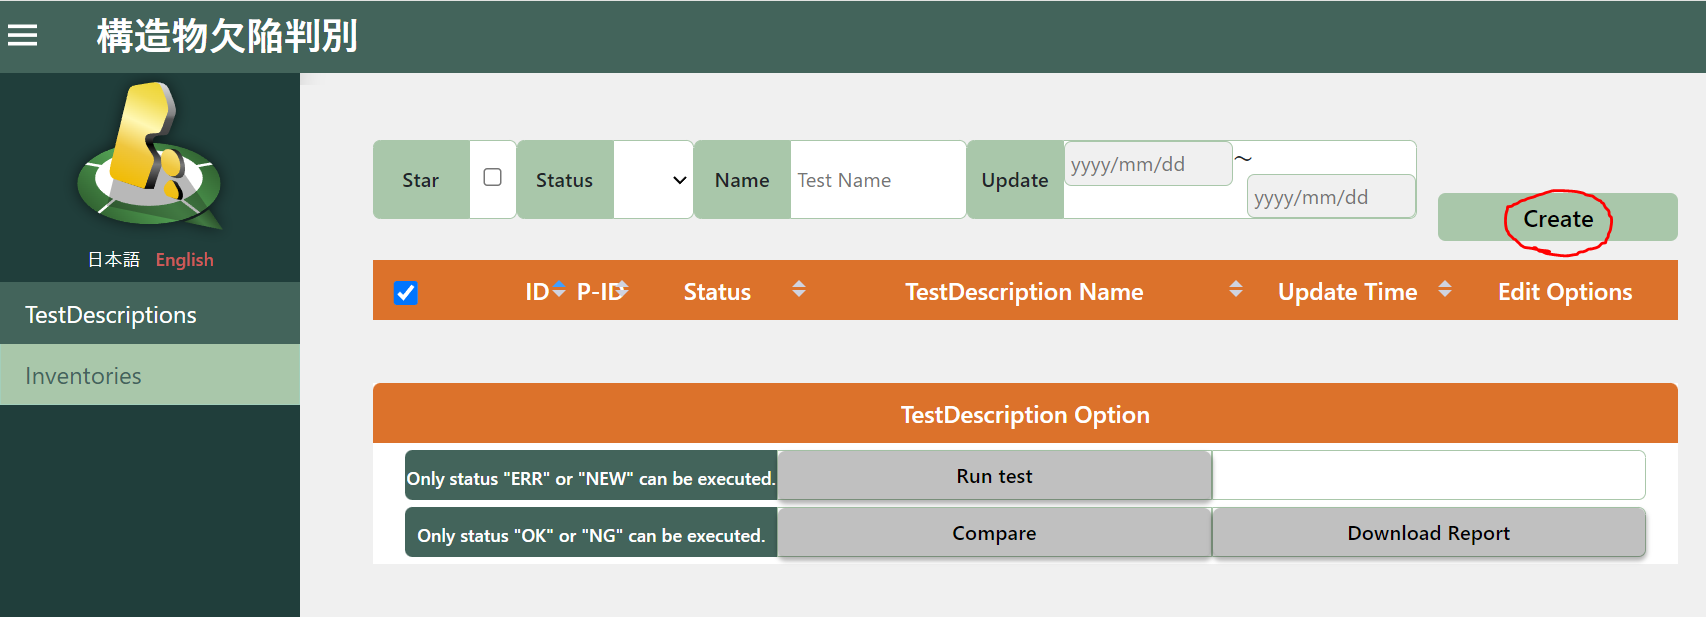

> 【手順2】下図の要領で必要事項を入力します。

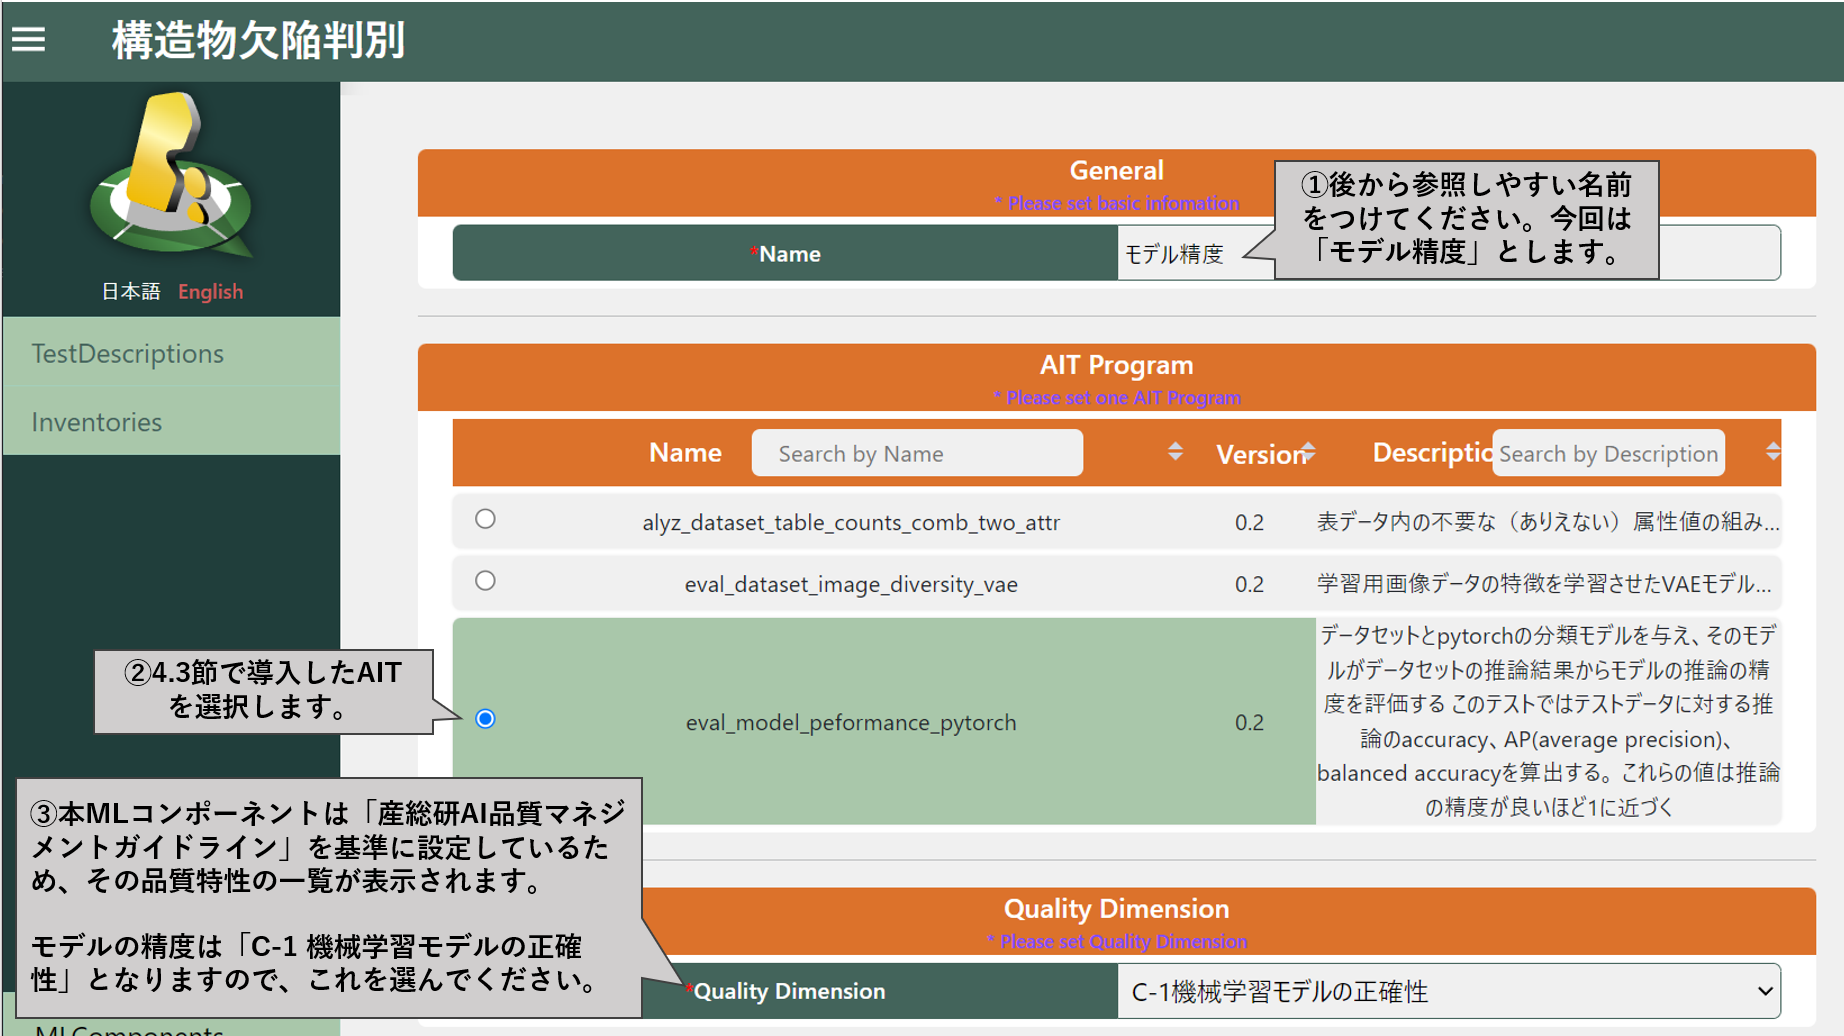

> 【手順3】テスト受け入れ基準を設定します。今回はテストですので、精度0.75以上を基準としておきましょう。
> また、今回のデータセットはデータの存在比率が欠陥有無で相当量異なるため、モデルがデータ存在比に依存しすぎていないかを確認する目的で、model_balanced_accuracyも0.65以上であることを要求することにします。

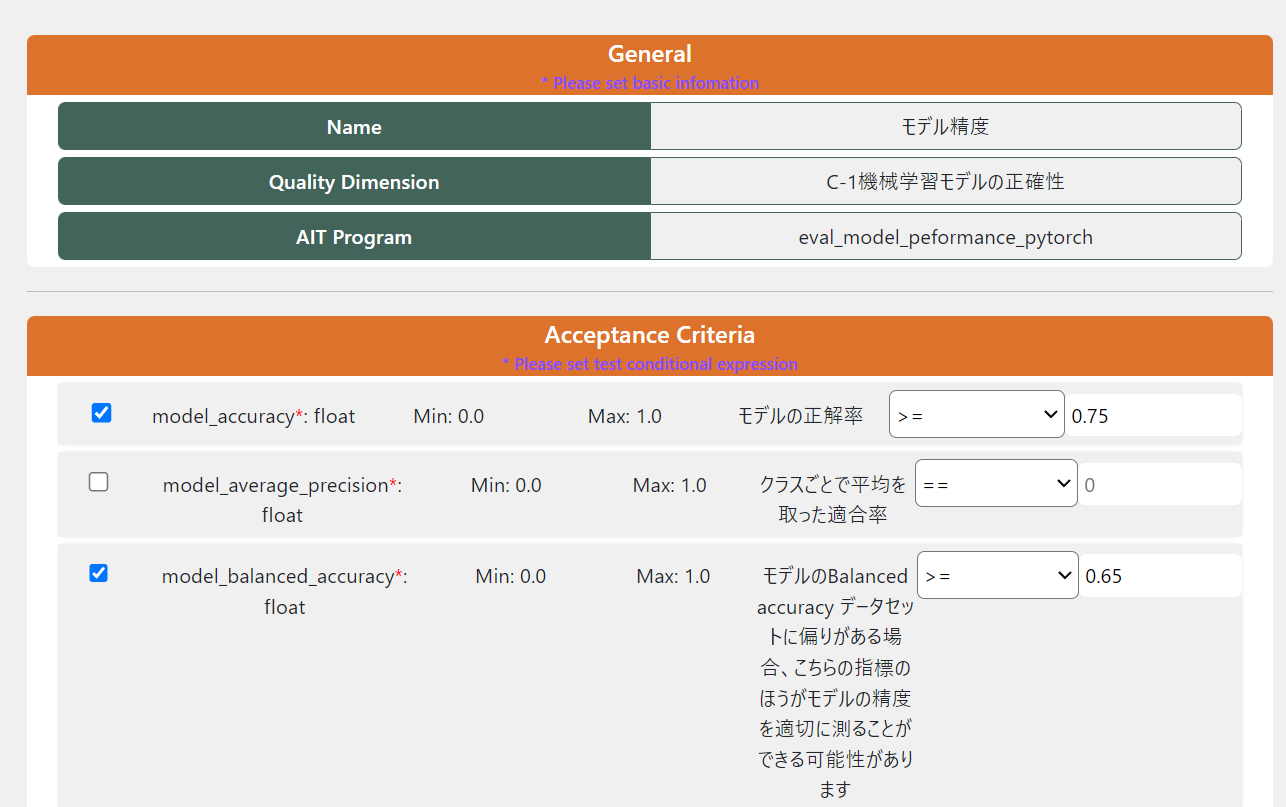

> 【手順3の続き】画面を下にスクロールし、AITの実行時に要求されるパラメータを入力してください。
> ここでは、HDF5形式のデータセット内に、データとラベルがそれぞれなんという名前で収められているかを入力する必要があります。
> 我々は3.2.2節末尾でそれぞれ"data", "label"と名付けましたので、これを入力します。
> また、テストで用いるデータセット・モデルを登録したインベントリと紐づけてください。
> 準備が完了したら、Createを押下してください。

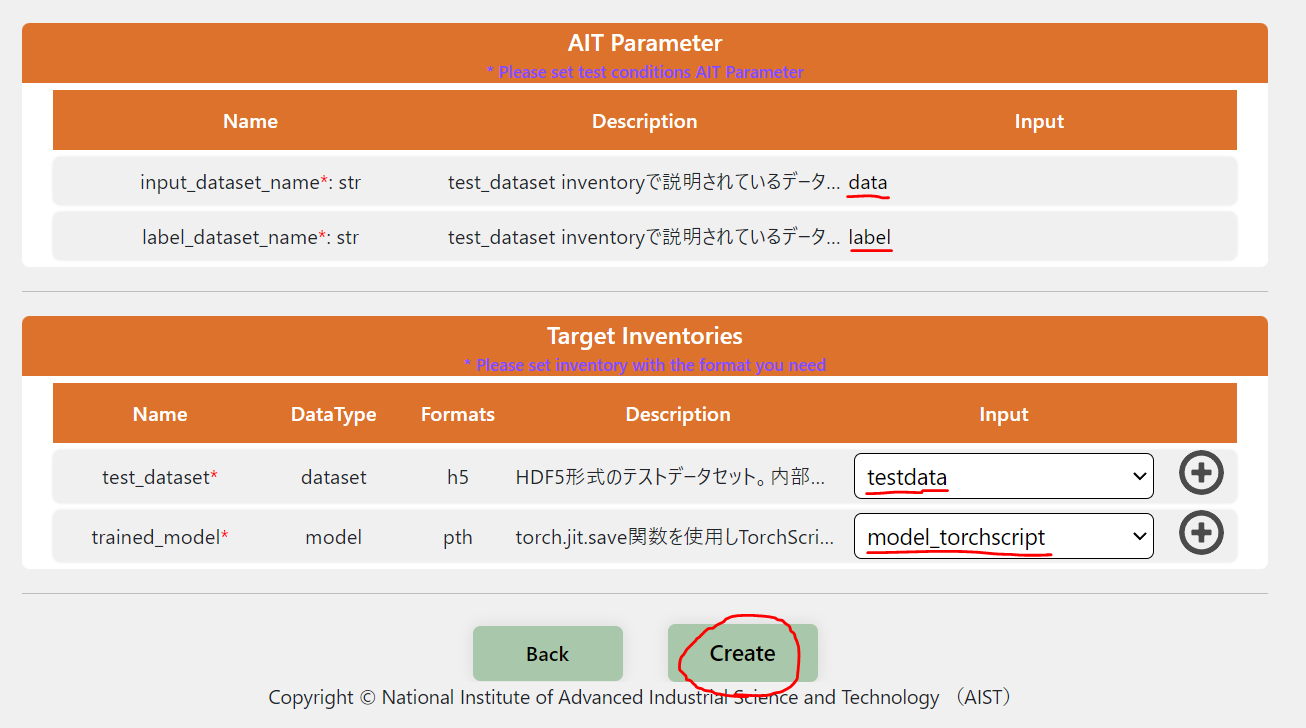

### 4.6.評価の実行と結果確認
#### 4.6.1.実行
> MLコンポ―ネントのテスト仕様画面に遷移し、4.5節で設定したテスト仕様にチェックを入れて、`Run Test`を押下してください。

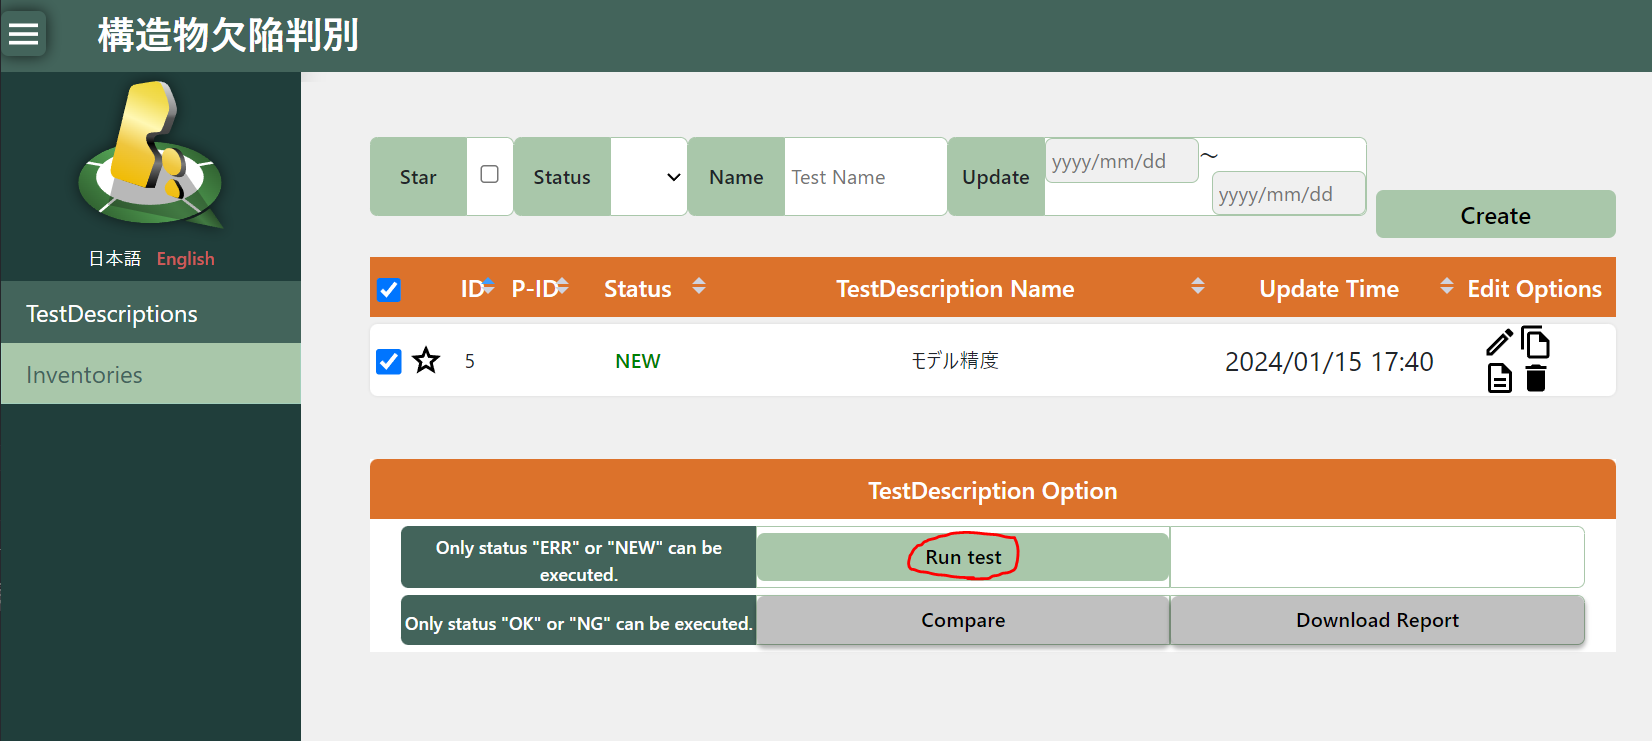

> テストはリアルタイムに実行され、状況も画面上に表示されます。
> 図示するように、Status:DONEと表示されれば評価が完了したことを表します。
> 次行の評価結果のうち、「OK」はすべての受け入れ基準を満たしたことを表し、「ERR」は受け入れ基準を満たさない項目があったことを表します。
> ※「ERR」「NA」は実行中になんらかの問題があったことを表します。エラー発生時にはログも閲覧できます。

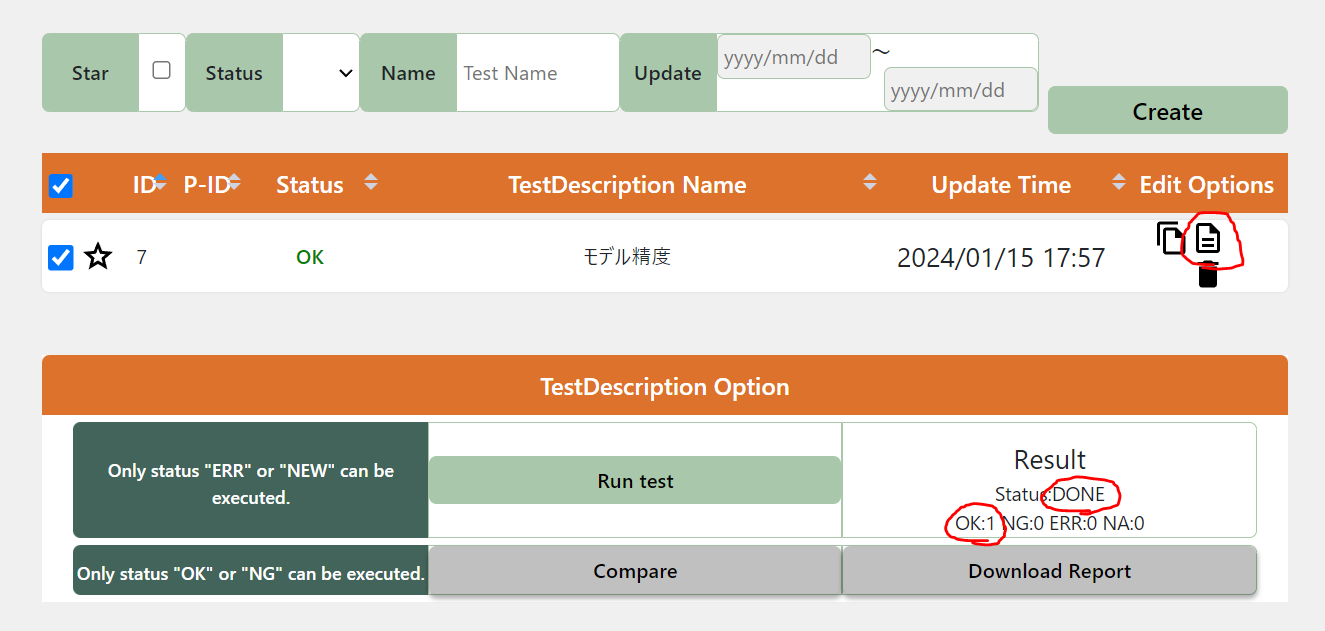

#### 4.6.2.モデル評価結果の確認
> 実行したテスト仕様の右列にある"detail"ボタン（資料のアイコン）をクリックすると結果の詳細を閲覧できます。
> この画面であなたのテスト結果に対する見解を入力してください。
> テスト結果が「OK」であることは、設定した受け入れ基準することを表しますが、最終的には人間が評価の実行結果を確認して判断する仕組みになっています。
> 以降はテスト結果画面の説明になります。

> 左上の領域ではAITが出力した参考情報（画像など）が出力されます。
> このAITは混同行列が出力されますので、異常ないことを確認してください。
> 今回はデータの存在比の影響もあり、欠陥あり（ID=0）を欠陥なし（ID=1）に誤認するケースがやや多いことがわかります。
> このような特性は、応用先システムによっては本テスト結果を受け入れないという結論になる場合もあるため、後述する見解欄に現時点での判断を記録するとよいでしょう。

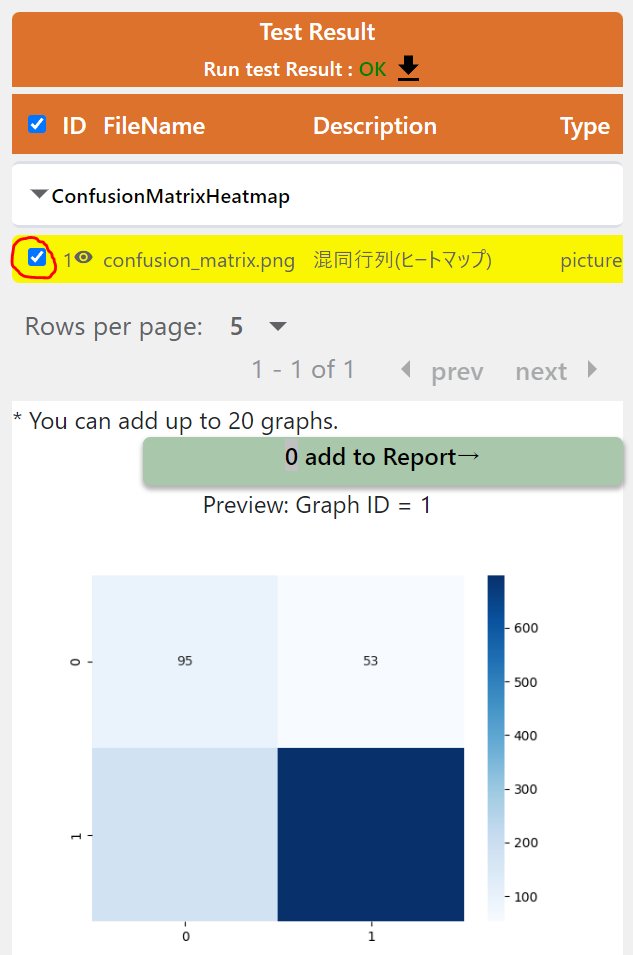

> この領域にはテスト結果の正確な値が表示されています。
> Measurementに計測値が、Descriptionにその説明が、そしてConditionに設定した受け入れ基準が表示されています。
> 今回は精度の要件も、バランス考慮精度の要件も満たしているため、この観点では問題ないと考えられます。

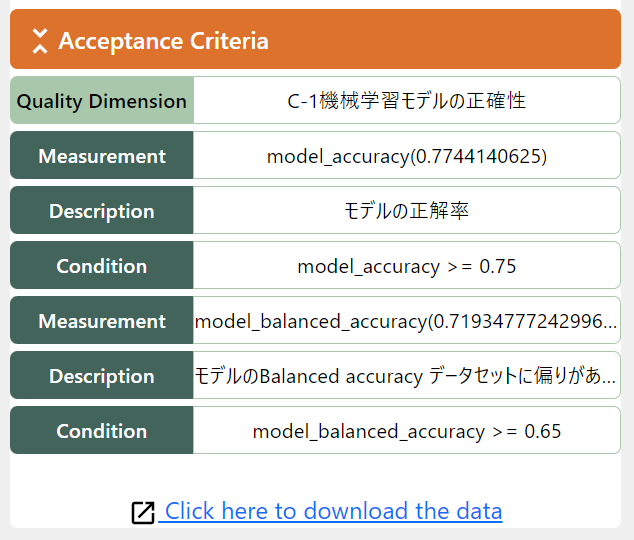

> 画面右が見解記入領域です。
> 上部は、AITが出力した画像のうちどれを最終的な結果ドキュメントに含めるかの設定ができます。
> 今回の結果に対して見解を記入し、Saveボタンを押下しましょう。

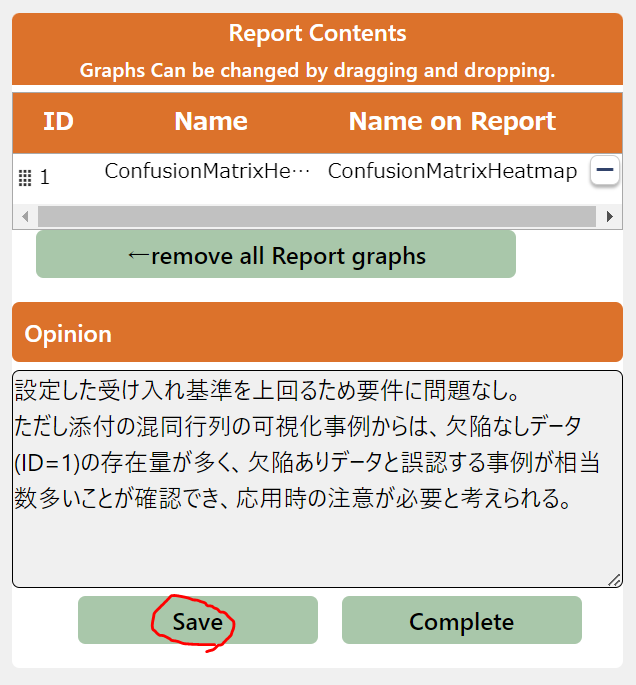

#### 4.6.3.データセット評価結果の確認
- データセットAITが未了のためスキップ。

### 4.7.品質レポートの作成
> テストが実行できましたので、実行したすべてのテストの結果をまとめた品質レポートを作成します。
> 前の画面に戻り、Download Reportボタンを押下してください。

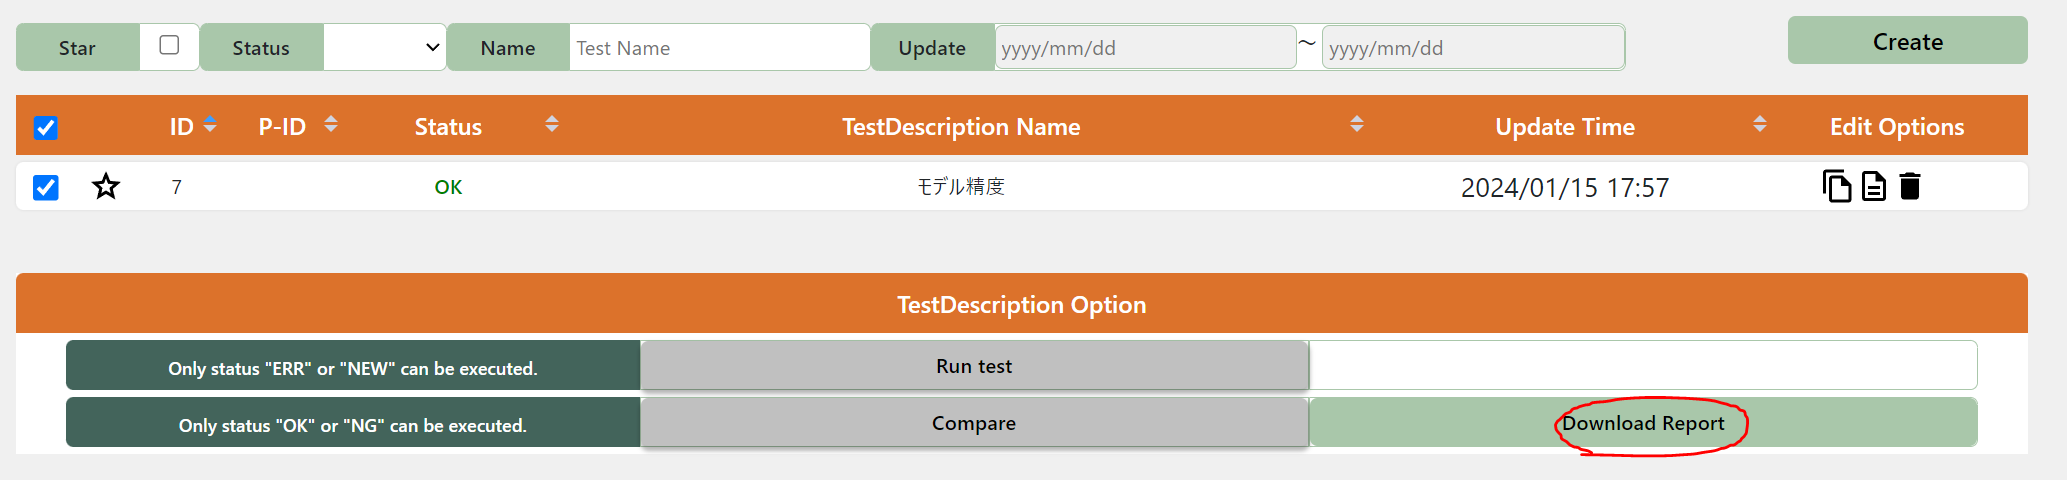

> レポート生成時に、ガイドライン・標準にあわせて体系的に結果出力を行いますので、テンプレートを選んでください。
> ここでは産総研AI品質マネジメントガイドライン（AIQMガイドライン）のテンプレートを選びます。

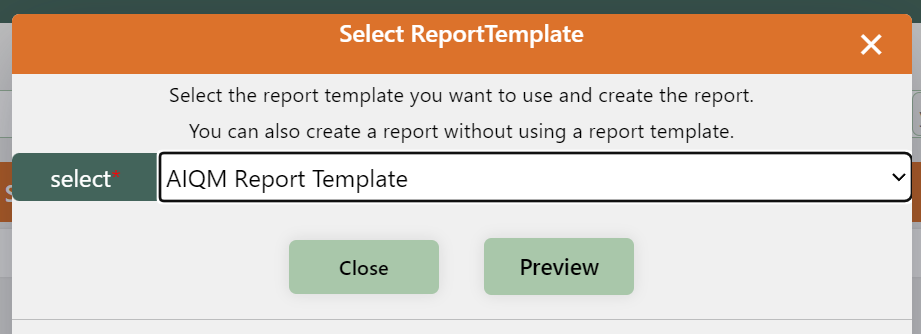

> プレビューから生成予定のレポートを閲覧できます。
> ページを送っていくと、2.11にてC-1の評価結果が出力されています。
> 受け入れ基準を通過したことを表す pass が表示され、入力した見解も表示されています。
> これにより、後からどの品質特性に対してどのような評価が行われ、どのような判断があったかを追跡することができます。

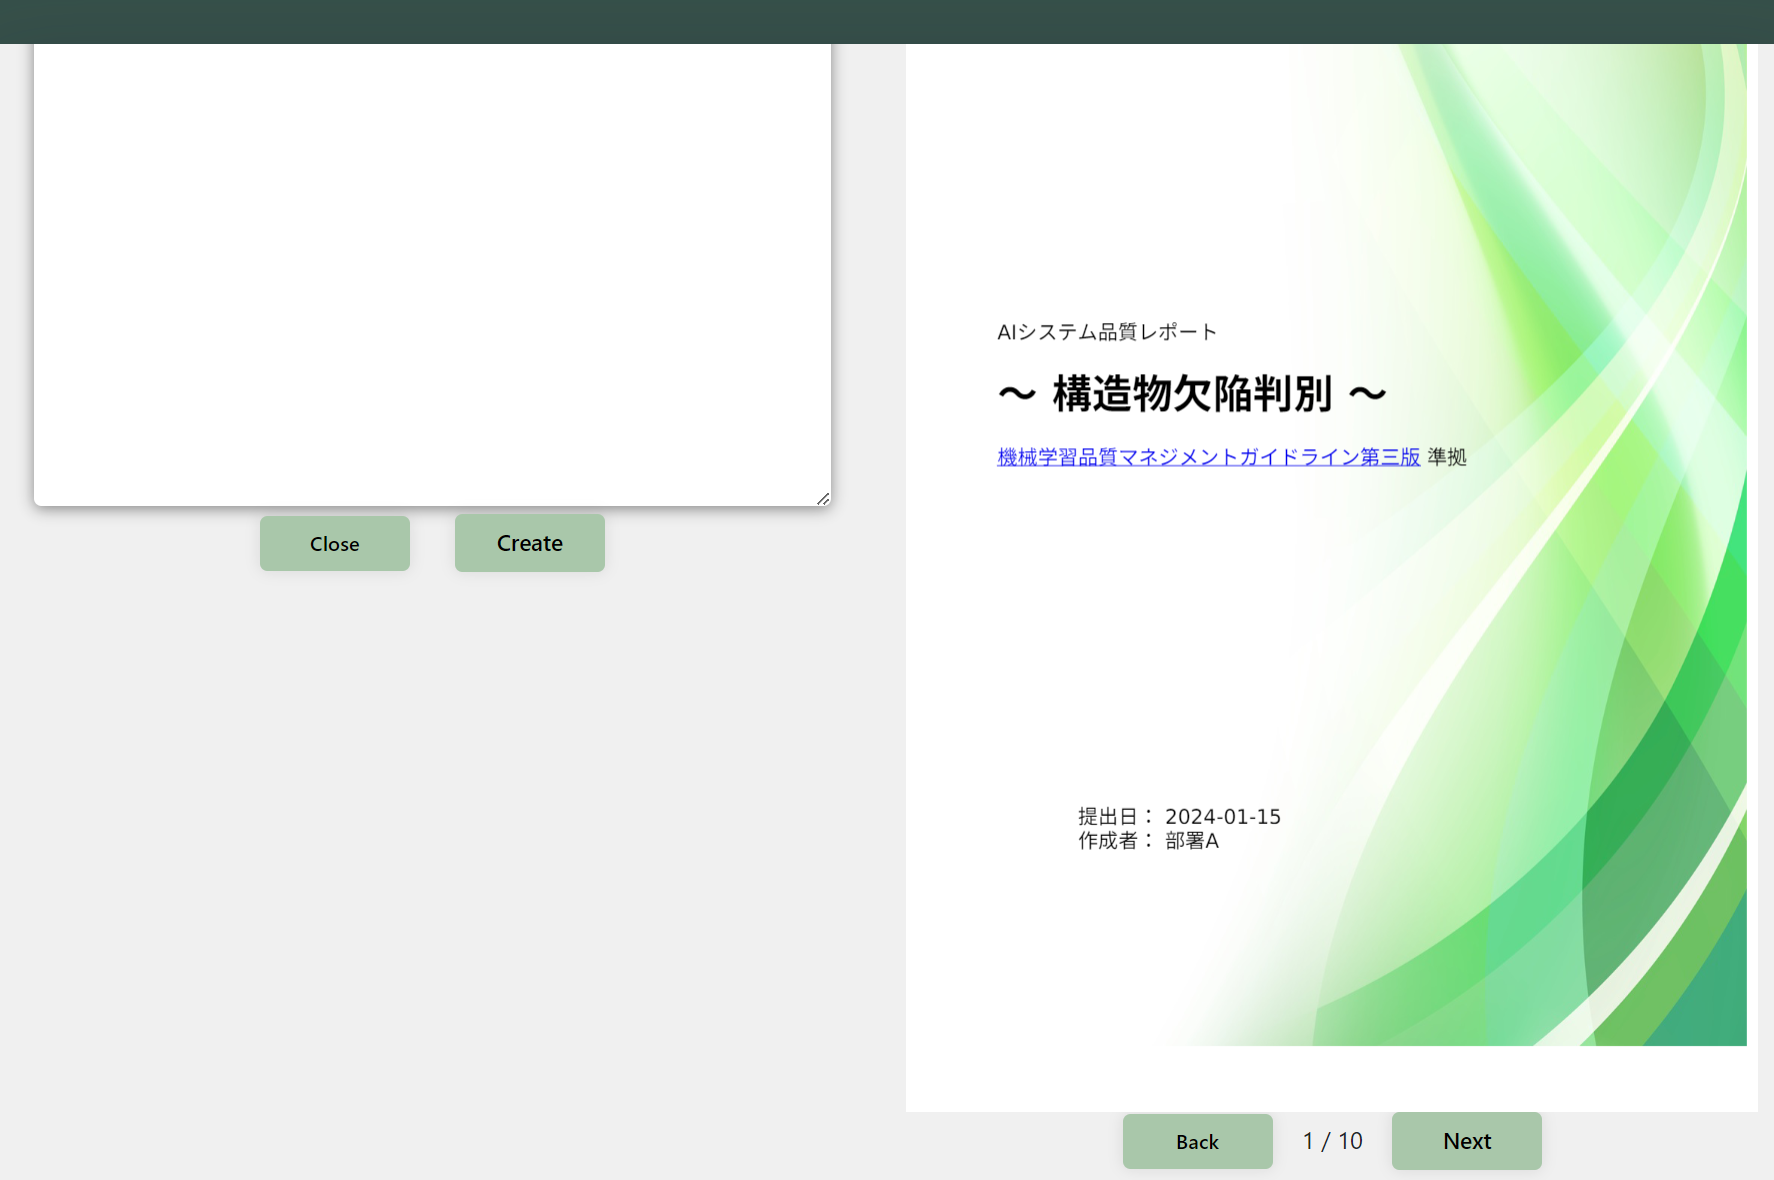
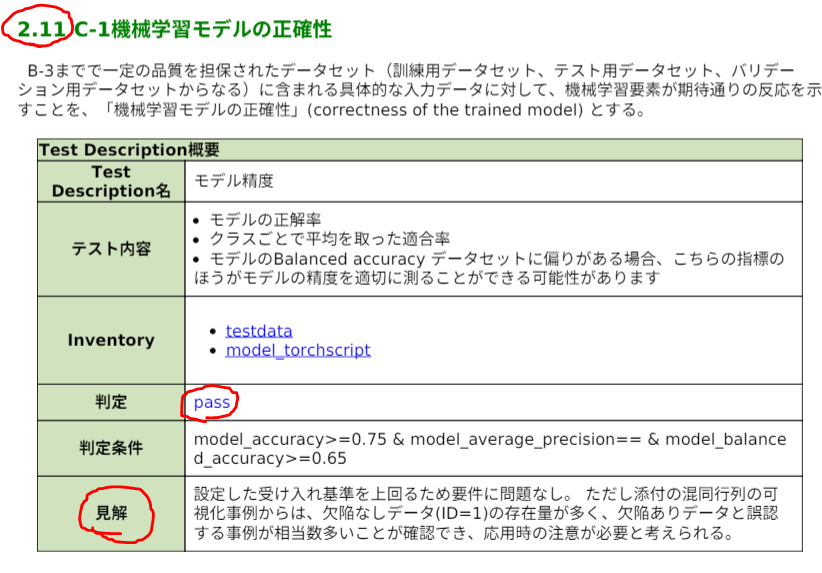

> 最後に画面左側よりレポートを生成しましょう。PDF形式でダウンロードされ、後から参照できるようになります。

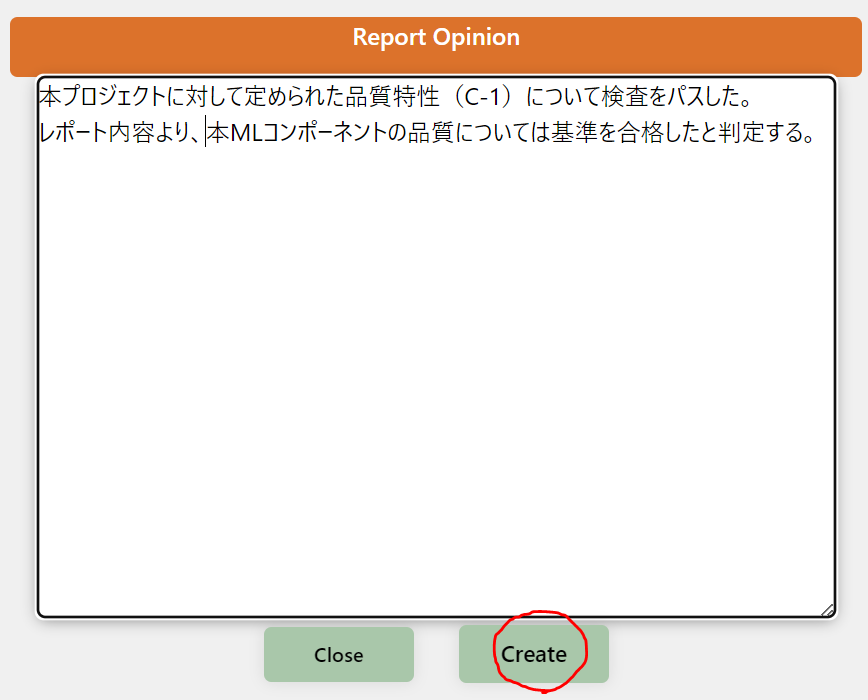

---

# 第二部 機械学習コンポーネントの準備方法
## 5. 推論モデルの準備

### 5.1 モデルの構築
簡単かつ高速に画像分類モデルの構築をするため、ここではtorchvisionを用いてMobileNet V3 Smallアーキテクチャのモデルを引用します。  
モデルオブジェクト作成時にはImageNetデータセットで訓練済の重みをロードします。  

今回のタスクは構造物の欠けの有無（二値分類）ですので、model.classifierの最終層を, out_features==2のLinear層で置き換えます。

In [1]:
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.nn import Linear
from torchsummary import summary
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1).to("cuda")

for name, param in model.named_parameters():  
    if "classifier" in name:
        continue
    param.requires_grad = False
model.classifier[-1] = Linear(1280, 2, bias=True).to("cuda")

summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             432
       BatchNorm2d-2           [-1, 16, 64, 64]              32
         Hardswish-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             256
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           1,024
      BatchNorm2d-11           [-1, 64, 64, 64]             128
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 32, 32]             576
      BatchNorm2d-14           [-1, 64,

### 5.2 モデルの訓練
ここからはモデルの訓練をしていきます。  
まずはデータセット準備で作成したSDNET2018splittedディレクトリを、Torchvision.datasets.ImageFolderクラスを用いて読み込みます。  
ImageFolderは指定されたディレクトリ直下のサブディレクトリに応じて分類クラスにインデックスを割り付けますので、予めこれを確認しておきます。

In [2]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2

# ImageNetで訓練済の重みを使用する際は、訓練時に下記の正規化処理が入っているため、再現
# また入力サイズは224*224に固定する。
normalize = v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
train_transform = v2.Compose([v2.RandomResizedCrop(224, antialias=None, scale=(0.8,1)), v2.RandomHorizontalFlip(), v2.RandomVerticalFlip(), v2.ToTensor(), normalize])
val_transform = v2.Compose([v2.Resize(224, antialias=None), v2.CenterCrop(224), v2.ToTensor(),  normalize])

# 訓練データと、過学習モデルの採用を防ぐためのvalデータを用意しておきます。
dataset = ImageFolder("../resources/SDNET2018splitted/train", transform=train_transform)
val_dataset = ImageFolder("../resources/SDNET2018splitted/val", transform=val_transform)

# 下記でどのサブディレクトリがどのクラスインデックスに割り当てられたかを確認できます。
dataset.class_to_idx

/root/.cache/pypoetry/virtualenvs/imono-tutorial-u5TcGW6f-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


{'Cracked': 0, 'Uncracked': 1}

In [3]:
import glob
Clen = len(glob.glob("../resources/SDNET2018splitted/train/Cracked/*"))
Ulen = len(glob.glob("../resources/SDNET2018splitted/train/Uncracked/*"))
Alllen = Clen + Ulen
print(f"{Clen/Alllen}, {Ulen/Alllen}")

0.15124908073897445, 0.8487509192610255


また、訓練データ内のCracked / Uncrackedの数を確認しておきます。

In [4]:
import glob
Clen = len(glob.glob("../resources/SDNET2018splitted/train/Cracked/*"))
Ulen = len(glob.glob("../resources/SDNET2018splitted/train/Uncracked/*"))
Alllen = Clen + Ulen
print(f"{Clen/Alllen}, {Ulen/Alllen}")

0.15124908073897445, 0.8487509192610255


それなりにImbalancedなデータですので、Lossに重みをつけておきます。  
データ量が少ない方の損失を重視する必要があるので、比率はデータ存在比の逆になります。

In [5]:
from torch.nn import CrossEntropyLoss
from torch import Tensor
loss_ratio = Tensor((Alllen/Clen, Alllen/Ulen)).to("cuda")
loss_fn = CrossEntropyLoss(loss_ratio)

残りの訓練設定は一般的な値を使っておきます。  
本シナリオでの説明に最低限必要な調整のみになっているため、必ずしも最適とは限らないことにご留意ください。

In [6]:
from torch.optim import Adam
from torch.utils.data import DataLoader
optimizer = Adam(model.parameters(), lr=1e-7)
train_loader = DataLoader(dataset,
                          batch_size=16,
                          shuffle=True,
                          num_workers=8,
                          pin_memory=True)
val_loader = DataLoader(val_dataset,
                        batch_size=16,
                        shuffle=False,
                        num_workers=8,
                        pin_memory=True)

In [7]:
from tqdm import tqdm
from torchmetrics import Accuracy
import torch

def train():
    train_batches = len(train_loader)
    best_val_loss = 10000
    
    for ix in range(150):
        # Imbalanced なデータですので、予めMacro AccuracyとMicro Accuracyを確認しておくことにします。
        macro_acc = Accuracy(task="multiclass", average="macro", num_classes=2).to("cuda")
        micro_acc = Accuracy(task="multiclass", average="micro", num_classes=2).to("cuda")
        epoch_loss = 0
        
        model.train()
        for jx, (data, target) in (tqdm_bar := tqdm(enumerate(train_loader))):
            data, target = data.to("cuda"), target.to("cuda")
            optimizer.zero_grad()
            
            output = model(data)
            
            loss = loss_fn(output, target)
            loss.backward()
            epoch_loss += loss
            
            macro_acc.update(output, target)
            micro_acc.update(output, target)
            
            optimizer.step()
            
            if jx % 100 == 0:
                tqdm_bar.set_description(f"[Epoch {ix}] [Batch {jx+1}/{train_batches}] Acc.={macro_acc.compute():.3f}, Loss={epoch_loss/(jx+1):.3f}")

        macro_acc.reset()
        micro_acc.reset()
        
        ## Validation
        model.eval()
        val_loss = 0
        
        for jx, (data, target) in enumerate(val_loader):
            data, target = data.to("cuda"), target.to("cuda")
            output = model(data)

            loss = loss_fn(output, target)
            val_loss += loss
            
            macro_acc.update(output, target)
            micro_acc.update(output, target)
            
        val_loss = val_loss / jx+1
        print(f"VALIDATION: (MACRO/MICRO Acc.)={macro_acc.compute():.3f}/{micro_acc.compute():.3f}, Loss={val_loss:.3f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '../resources/best_model.pth')
            
        macro_acc.reset()
        micro_acc.reset()

train()

[Epoch 0] [Batch 2801/2805] Acc.=0.507, Loss=0.717: : 2805it [01:37, 28.77it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.523/0.253, Loss=1.893


[Epoch 1] [Batch 2801/2805] Acc.=0.505, Loss=0.711: : 2805it [01:39, 28.29it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.528/0.282, Loss=1.861


[Epoch 2] [Batch 2801/2805] Acc.=0.520, Loss=0.706: : 2805it [01:34, 29.68it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.531/0.297, Loss=1.842


[Epoch 3] [Batch 2801/2805] Acc.=0.529, Loss=0.699: : 2805it [01:35, 29.34it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.539/0.310, Loss=1.830


[Epoch 4] [Batch 2801/2805] Acc.=0.537, Loss=0.693: : 2805it [01:35, 29.32it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.549/0.336, Loss=1.814


[Epoch 5] [Batch 2801/2805] Acc.=0.548, Loss=0.689: : 2805it [01:34, 29.57it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.550/0.335, Loss=1.810


[Epoch 6] [Batch 2801/2805] Acc.=0.553, Loss=0.684: : 2805it [01:36, 29.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.555/0.346, Loss=1.801


[Epoch 7] [Batch 2801/2805] Acc.=0.558, Loss=0.681: : 2805it [01:35, 29.49it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.572/0.388, Loss=1.776


[Epoch 8] [Batch 2801/2805] Acc.=0.561, Loss=0.679: : 2805it [01:36, 29.10it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.571/0.375, Loss=1.783


[Epoch 9] [Batch 2801/2805] Acc.=0.567, Loss=0.677: : 2805it [01:36, 29.14it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.572/0.373, Loss=1.783


[Epoch 10] [Batch 2801/2805] Acc.=0.576, Loss=0.674: : 2805it [01:35, 29.30it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.589/0.410, Loss=1.763


[Epoch 11] [Batch 2801/2805] Acc.=0.575, Loss=0.671: : 2805it [01:36, 29.21it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.589/0.407, Loss=1.760


[Epoch 12] [Batch 2801/2805] Acc.=0.580, Loss=0.669: : 2805it [01:36, 28.93it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.594/0.420, Loss=1.754


[Epoch 13] [Batch 2801/2805] Acc.=0.587, Loss=0.665: : 2805it [01:35, 29.25it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.602/0.437, Loss=1.744


[Epoch 14] [Batch 2801/2805] Acc.=0.587, Loss=0.665: : 2805it [01:36, 29.12it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.607/0.446, Loss=1.740


[Epoch 15] [Batch 2801/2805] Acc.=0.592, Loss=0.663: : 2805it [01:35, 29.29it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.608/0.449, Loss=1.736


[Epoch 16] [Batch 2801/2805] Acc.=0.599, Loss=0.657: : 2805it [01:35, 29.25it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.613/0.458, Loss=1.732


[Epoch 17] [Batch 2801/2805] Acc.=0.602, Loss=0.656: : 2805it [01:35, 29.23it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.613/0.460, Loss=1.728


[Epoch 18] [Batch 2801/2805] Acc.=0.606, Loss=0.654: : 2805it [01:35, 29.52it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.628/0.486, Loss=1.717


[Epoch 19] [Batch 2801/2805] Acc.=0.607, Loss=0.654: : 2805it [01:35, 29.47it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.633/0.501, Loss=1.707


[Epoch 20] [Batch 2801/2805] Acc.=0.614, Loss=0.649: : 2805it [01:36, 29.17it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.641/0.514, Loss=1.703


[Epoch 21] [Batch 2801/2805] Acc.=0.610, Loss=0.649: : 2805it [01:35, 29.28it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.642/0.514, Loss=1.701


[Epoch 22] [Batch 2801/2805] Acc.=0.616, Loss=0.647: : 2805it [01:35, 29.49it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.648/0.527, Loss=1.694


[Epoch 23] [Batch 2801/2805] Acc.=0.611, Loss=0.649: : 2805it [01:35, 29.51it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.653/0.541, Loss=1.687


[Epoch 24] [Batch 2801/2805] Acc.=0.615, Loss=0.643: : 2805it [01:35, 29.34it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.656/0.551, Loss=1.682


[Epoch 25] [Batch 2801/2805] Acc.=0.619, Loss=0.643: : 2805it [01:35, 29.50it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.657/0.550, Loss=1.682


[Epoch 26] [Batch 2801/2805] Acc.=0.621, Loss=0.643: : 2805it [01:35, 29.31it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.661/0.558, Loss=1.679


[Epoch 27] [Batch 2801/2805] Acc.=0.623, Loss=0.642: : 2805it [01:35, 29.51it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.665/0.574, Loss=1.669


[Epoch 28] [Batch 2801/2805] Acc.=0.625, Loss=0.640: : 2805it [01:35, 29.49it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.669/0.577, Loss=1.668


[Epoch 29] [Batch 2801/2805] Acc.=0.631, Loss=0.635: : 2805it [01:34, 29.65it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.669/0.573, Loss=1.670


[Epoch 30] [Batch 2801/2805] Acc.=0.627, Loss=0.635: : 2805it [01:34, 29.62it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.674/0.584, Loss=1.663


[Epoch 31] [Batch 2801/2805] Acc.=0.625, Loss=0.637: : 2805it [01:35, 29.30it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.681/0.601, Loss=1.656


[Epoch 32] [Batch 2801/2805] Acc.=0.628, Loss=0.633: : 2805it [01:35, 29.50it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.683/0.616, Loss=1.646


[Epoch 33] [Batch 2801/2805] Acc.=0.636, Loss=0.631: : 2805it [01:35, 29.51it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.685/0.609, Loss=1.650


[Epoch 34] [Batch 2801/2805] Acc.=0.633, Loss=0.633: : 2805it [01:35, 29.52it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.684/0.622, Loss=1.642


[Epoch 35] [Batch 2801/2805] Acc.=0.635, Loss=0.630: : 2805it [01:39, 28.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.688/0.618, Loss=1.646


[Epoch 36] [Batch 2801/2805] Acc.=0.637, Loss=0.630: : 2805it [01:34, 29.56it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.691/0.635, Loss=1.634


[Epoch 37] [Batch 2801/2805] Acc.=0.640, Loss=0.627: : 2805it [01:36, 29.17it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.692/0.648, Loss=1.627


[Epoch 38] [Batch 2801/2805] Acc.=0.634, Loss=0.629: : 2805it [01:37, 28.85it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.695/0.634, Loss=1.635


[Epoch 39] [Batch 2801/2805] Acc.=0.643, Loss=0.624: : 2805it [01:36, 29.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.696/0.642, Loss=1.631


[Epoch 40] [Batch 2801/2805] Acc.=0.645, Loss=0.624: : 2805it [01:36, 28.93it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.694/0.636, Loss=1.631


[Epoch 41] [Batch 2801/2805] Acc.=0.644, Loss=0.623: : 2805it [01:39, 28.29it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.702/0.649, Loss=1.626


[Epoch 42] [Batch 2801/2805] Acc.=0.644, Loss=0.624: : 2805it [01:32, 30.23it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.706/0.662, Loss=1.618


[Epoch 43] [Batch 2801/2805] Acc.=0.641, Loss=0.624: : 2805it [01:33, 30.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.702/0.643, Loss=1.629


[Epoch 44] [Batch 2801/2805] Acc.=0.645, Loss=0.623: : 2805it [01:33, 29.94it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.702/0.662, Loss=1.616


[Epoch 45] [Batch 2801/2805] Acc.=0.642, Loss=0.622: : 2805it [01:33, 29.92it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.705/0.657, Loss=1.620


[Epoch 46] [Batch 2801/2805] Acc.=0.646, Loss=0.619: : 2805it [01:33, 29.90it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.706/0.672, Loss=1.609


[Epoch 47] [Batch 2801/2805] Acc.=0.646, Loss=0.619: : 2805it [01:33, 30.06it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.705/0.667, Loss=1.612


[Epoch 48] [Batch 2801/2805] Acc.=0.649, Loss=0.619: : 2805it [01:32, 30.32it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.710/0.672, Loss=1.611


[Epoch 49] [Batch 2801/2805] Acc.=0.644, Loss=0.620: : 2805it [01:32, 30.21it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.705/0.674, Loss=1.607


[Epoch 50] [Batch 2801/2805] Acc.=0.649, Loss=0.620: : 2805it [01:34, 29.53it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.706/0.670, Loss=1.609


[Epoch 51] [Batch 2801/2805] Acc.=0.651, Loss=0.616: : 2805it [01:33, 29.99it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.713/0.692, Loss=1.596


[Epoch 52] [Batch 2801/2805] Acc.=0.650, Loss=0.616: : 2805it [01:33, 30.09it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.714/0.695, Loss=1.594


[Epoch 53] [Batch 2801/2805] Acc.=0.651, Loss=0.618: : 2805it [01:33, 30.07it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.719/0.700, Loss=1.591


[Epoch 54] [Batch 2801/2805] Acc.=0.652, Loss=0.614: : 2805it [01:32, 30.21it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.716/0.693, Loss=1.595


[Epoch 55] [Batch 2801/2805] Acc.=0.651, Loss=0.615: : 2805it [01:33, 29.87it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.710/0.694, Loss=1.593


[Epoch 56] [Batch 2801/2805] Acc.=0.648, Loss=0.616: : 2805it [01:32, 30.23it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.712/0.697, Loss=1.592


[Epoch 57] [Batch 2801/2805] Acc.=0.648, Loss=0.613: : 2805it [01:33, 30.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.712/0.682, Loss=1.600


[Epoch 58] [Batch 2801/2805] Acc.=0.652, Loss=0.612: : 2805it [01:33, 30.11it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.715/0.711, Loss=1.582


[Epoch 59] [Batch 2801/2805] Acc.=0.653, Loss=0.614: : 2805it [01:33, 30.05it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.718/0.708, Loss=1.583


[Epoch 60] [Batch 2801/2805] Acc.=0.653, Loss=0.611: : 2805it [01:33, 29.98it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.717/0.707, Loss=1.583


[Epoch 61] [Batch 2801/2805] Acc.=0.655, Loss=0.612: : 2805it [01:33, 30.01it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.717/0.713, Loss=1.581


[Epoch 62] [Batch 2801/2805] Acc.=0.660, Loss=0.610: : 2805it [01:33, 30.09it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.728, Loss=1.571


[Epoch 63] [Batch 2801/2805] Acc.=0.657, Loss=0.610: : 2805it [01:33, 30.08it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.721/0.711, Loss=1.579


[Epoch 64] [Batch 2801/2805] Acc.=0.655, Loss=0.610: : 2805it [01:34, 29.83it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.720/0.708, Loss=1.582


[Epoch 65] [Batch 2801/2805] Acc.=0.656, Loss=0.609: : 2805it [01:32, 30.28it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.719/0.719, Loss=1.574


[Epoch 66] [Batch 2801/2805] Acc.=0.653, Loss=0.610: : 2805it [01:32, 30.21it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.728, Loss=1.568


[Epoch 67] [Batch 2801/2805] Acc.=0.656, Loss=0.608: : 2805it [01:33, 30.06it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.724, Loss=1.569


[Epoch 68] [Batch 2801/2805] Acc.=0.658, Loss=0.607: : 2805it [01:33, 29.97it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.731, Loss=1.565


[Epoch 69] [Batch 2801/2805] Acc.=0.657, Loss=0.607: : 2805it [01:34, 29.58it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.722/0.721, Loss=1.572


[Epoch 70] [Batch 2801/2805] Acc.=0.664, Loss=0.604: : 2805it [01:34, 29.61it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.729, Loss=1.566


[Epoch 71] [Batch 2801/2805] Acc.=0.657, Loss=0.608: : 2805it [01:33, 30.02it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.723, Loss=1.567


[Epoch 72] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:33, 30.08it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.729, Loss=1.565


[Epoch 73] [Batch 2801/2805] Acc.=0.662, Loss=0.602: : 2805it [01:33, 30.13it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.740, Loss=1.558


[Epoch 74] [Batch 2801/2805] Acc.=0.656, Loss=0.607: : 2805it [01:38, 28.61it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.742, Loss=1.554


[Epoch 75] [Batch 2801/2805] Acc.=0.654, Loss=0.609: : 2805it [01:33, 29.92it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.734, Loss=1.560


[Epoch 76] [Batch 2801/2805] Acc.=0.658, Loss=0.605: : 2805it [01:34, 29.65it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.725, Loss=1.565


[Epoch 77] [Batch 2801/2805] Acc.=0.658, Loss=0.605: : 2805it [01:33, 29.91it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.729, Loss=1.564


[Epoch 78] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:32, 30.31it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.734, Loss=1.560


[Epoch 79] [Batch 2801/2805] Acc.=0.656, Loss=0.607: : 2805it [01:33, 30.09it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.744, Loss=1.554


[Epoch 80] [Batch 2801/2805] Acc.=0.656, Loss=0.608: : 2805it [01:32, 30.18it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.729, Loss=1.564


[Epoch 81] [Batch 2801/2805] Acc.=0.660, Loss=0.606: : 2805it [01:33, 29.99it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.729, Loss=1.563


[Epoch 82] [Batch 2801/2805] Acc.=0.661, Loss=0.604: : 2805it [01:33, 29.84it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.739, Loss=1.558


[Epoch 83] [Batch 2801/2805] Acc.=0.656, Loss=0.607: : 2805it [01:32, 30.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.736, Loss=1.560


[Epoch 84] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:34, 29.72it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.724/0.724, Loss=1.566


[Epoch 85] [Batch 2801/2805] Acc.=0.657, Loss=0.606: : 2805it [01:33, 30.10it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.732, Loss=1.562


[Epoch 86] [Batch 2801/2805] Acc.=0.658, Loss=0.605: : 2805it [01:33, 30.14it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.737, Loss=1.560


[Epoch 87] [Batch 2801/2805] Acc.=0.656, Loss=0.606: : 2805it [01:33, 29.96it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.733, Loss=1.560


[Epoch 88] [Batch 2801/2805] Acc.=0.661, Loss=0.606: : 2805it [01:33, 30.06it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.734, Loss=1.559


[Epoch 89] [Batch 2801/2805] Acc.=0.661, Loss=0.602: : 2805it [01:33, 29.91it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.732, Loss=1.561


[Epoch 90] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:34, 29.69it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.725, Loss=1.567


[Epoch 91] [Batch 2801/2805] Acc.=0.660, Loss=0.603: : 2805it [01:34, 29.72it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.726, Loss=1.567


[Epoch 92] [Batch 2801/2805] Acc.=0.659, Loss=0.605: : 2805it [01:33, 30.08it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.746, Loss=1.553


[Epoch 93] [Batch 2801/2805] Acc.=0.659, Loss=0.605: : 2805it [01:35, 29.46it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.741, Loss=1.554


[Epoch 94] [Batch 2801/2805] Acc.=0.660, Loss=0.604: : 2805it [01:32, 30.31it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.738, Loss=1.557


[Epoch 95] [Batch 2801/2805] Acc.=0.661, Loss=0.606: : 2805it [01:33, 30.03it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.738, Loss=1.558


[Epoch 96] [Batch 2801/2805] Acc.=0.660, Loss=0.604: : 2805it [01:32, 30.37it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.728, Loss=1.563


[Epoch 97] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:32, 30.18it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.733, Loss=1.560


[Epoch 98] [Batch 2801/2805] Acc.=0.665, Loss=0.601: : 2805it [01:33, 30.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.744, Loss=1.554


[Epoch 99] [Batch 2801/2805] Acc.=0.661, Loss=0.606: : 2805it [01:33, 30.07it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.738, Loss=1.558


[Epoch 100] [Batch 2801/2805] Acc.=0.662, Loss=0.603: : 2805it [01:33, 30.10it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.725, Loss=1.565


[Epoch 101] [Batch 2801/2805] Acc.=0.665, Loss=0.601: : 2805it [01:32, 30.25it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.734, Loss=1.561


[Epoch 102] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:32, 30.18it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.735, Loss=1.559


[Epoch 103] [Batch 2801/2805] Acc.=0.663, Loss=0.604: : 2805it [01:36, 29.11it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.738, Loss=1.558


[Epoch 104] [Batch 2801/2805] Acc.=0.658, Loss=0.604: : 2805it [01:36, 29.02it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.735, Loss=1.557


[Epoch 105] [Batch 2801/2805] Acc.=0.657, Loss=0.608: : 2805it [01:32, 30.19it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.725, Loss=1.565


[Epoch 106] [Batch 2801/2805] Acc.=0.663, Loss=0.601: : 2805it [01:32, 30.24it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.728, Loss=1.564


[Epoch 107] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:33, 30.12it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.728, Loss=1.562


[Epoch 108] [Batch 2801/2805] Acc.=0.662, Loss=0.602: : 2805it [01:33, 30.00it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.747, Loss=1.550


[Epoch 109] [Batch 2801/2805] Acc.=0.658, Loss=0.605: : 2805it [01:34, 29.66it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.739, Loss=1.557


[Epoch 110] [Batch 2801/2805] Acc.=0.663, Loss=0.602: : 2805it [01:36, 29.12it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.727, Loss=1.563


[Epoch 111] [Batch 2801/2805] Acc.=0.659, Loss=0.607: : 2805it [01:33, 30.11it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.730, Loss=1.563


[Epoch 112] [Batch 2801/2805] Acc.=0.661, Loss=0.605: : 2805it [01:32, 30.34it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.735, Loss=1.557


[Epoch 113] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:33, 30.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.734, Loss=1.559


[Epoch 114] [Batch 2801/2805] Acc.=0.662, Loss=0.605: : 2805it [01:32, 30.19it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.735, Loss=1.559


[Epoch 115] [Batch 2801/2805] Acc.=0.659, Loss=0.604: : 2805it [01:33, 30.10it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.738, Loss=1.557


[Epoch 116] [Batch 2801/2805] Acc.=0.659, Loss=0.603: : 2805it [01:34, 29.82it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.739, Loss=1.557


[Epoch 117] [Batch 2801/2805] Acc.=0.663, Loss=0.601: : 2805it [01:34, 29.84it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.731, Loss=1.561


[Epoch 118] [Batch 2801/2805] Acc.=0.662, Loss=0.604: : 2805it [01:33, 30.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.732, Loss=1.560


[Epoch 119] [Batch 2801/2805] Acc.=0.661, Loss=0.600: : 2805it [01:33, 29.95it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.738, Loss=1.557


[Epoch 120] [Batch 2801/2805] Acc.=0.663, Loss=0.604: : 2805it [01:33, 30.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.743, Loss=1.554


[Epoch 121] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:32, 30.17it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.733, Loss=1.559


[Epoch 122] [Batch 2801/2805] Acc.=0.659, Loss=0.604: : 2805it [01:34, 29.70it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.746, Loss=1.551


[Epoch 123] [Batch 2801/2805] Acc.=0.660, Loss=0.604: : 2805it [01:32, 30.25it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.734, Loss=1.559


[Epoch 124] [Batch 2801/2805] Acc.=0.660, Loss=0.604: : 2805it [01:34, 29.65it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.744, Loss=1.552


[Epoch 125] [Batch 2801/2805] Acc.=0.658, Loss=0.606: : 2805it [01:33, 30.12it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.739, Loss=1.557


[Epoch 126] [Batch 2801/2805] Acc.=0.662, Loss=0.602: : 2805it [01:33, 30.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.733, Loss=1.560


[Epoch 127] [Batch 2801/2805] Acc.=0.662, Loss=0.605: : 2805it [01:33, 30.04it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.734, Loss=1.559


[Epoch 128] [Batch 2801/2805] Acc.=0.667, Loss=0.601: : 2805it [01:32, 30.21it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.725/0.735, Loss=1.558


[Epoch 129] [Batch 2801/2805] Acc.=0.661, Loss=0.605: : 2805it [01:33, 30.05it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.734, Loss=1.559


[Epoch 130] [Batch 2801/2805] Acc.=0.664, Loss=0.602: : 2805it [01:33, 30.05it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.726/0.742, Loss=1.553


[Epoch 131] [Batch 2801/2805] Acc.=0.660, Loss=0.602: : 2805it [01:33, 29.94it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.745, Loss=1.553


[Epoch 132] [Batch 2801/2805] Acc.=0.659, Loss=0.603: : 2805it [01:33, 30.05it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.743, Loss=1.552


[Epoch 133] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:34, 29.66it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.734, Loss=1.559


[Epoch 134] [Batch 2801/2805] Acc.=0.664, Loss=0.600: : 2805it [01:32, 30.28it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.736, Loss=1.558


[Epoch 135] [Batch 2801/2805] Acc.=0.665, Loss=0.600: : 2805it [01:33, 30.10it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.723/0.717, Loss=1.569


[Epoch 136] [Batch 2801/2805] Acc.=0.657, Loss=0.605: : 2805it [01:32, 30.18it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.748, Loss=1.550


[Epoch 137] [Batch 2801/2805] Acc.=0.659, Loss=0.606: : 2805it [01:33, 30.02it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.739, Loss=1.556


[Epoch 138] [Batch 2801/2805] Acc.=0.663, Loss=0.602: : 2805it [01:34, 29.60it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.728, Loss=1.564


[Epoch 139] [Batch 2801/2805] Acc.=0.660, Loss=0.605: : 2805it [01:34, 29.65it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.731/0.736, Loss=1.558


[Epoch 140] [Batch 2801/2805] Acc.=0.665, Loss=0.600: : 2805it [01:33, 30.13it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.740, Loss=1.554


[Epoch 141] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:33, 30.03it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.730/0.741, Loss=1.555


[Epoch 142] [Batch 2801/2805] Acc.=0.657, Loss=0.605: : 2805it [01:33, 29.91it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.739, Loss=1.557


[Epoch 143] [Batch 2801/2805] Acc.=0.665, Loss=0.602: : 2805it [01:33, 30.09it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.733/0.748, Loss=1.550


[Epoch 144] [Batch 2801/2805] Acc.=0.659, Loss=0.603: : 2805it [01:33, 30.14it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.744, Loss=1.550


[Epoch 145] [Batch 2801/2805] Acc.=0.659, Loss=0.605: : 2805it [01:33, 30.11it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.729/0.742, Loss=1.554


[Epoch 146] [Batch 2801/2805] Acc.=0.662, Loss=0.602: : 2805it [01:34, 29.83it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.733/0.751, Loss=1.548


[Epoch 147] [Batch 2801/2805] Acc.=0.661, Loss=0.603: : 2805it [01:33, 29.94it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.727/0.730, Loss=1.561


[Epoch 148] [Batch 2801/2805] Acc.=0.662, Loss=0.604: : 2805it [01:33, 30.15it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.731/0.743, Loss=1.553


[Epoch 149] [Batch 2801/2805] Acc.=0.662, Loss=0.603: : 2805it [01:32, 30.16it/s]


VALIDATION: (MACRO/MICRO Acc.)=0.728/0.737, Loss=1.555


### モデルの検証
モデル訓練完了後、全エポックを通じて最良（検証データセットでの損失が最小）のモデルが `../resources/best_model.pth` に保存されます。


### データセットの評価